# Conditional variational autoencoder (using the VAE class)

# SETUP

In [1]:
!python --version


Python 3.6.7


In [2]:
%%bash
git clone https://github.com/masa-su/pixyz.git

fatal: destination path 'pixyz' already exists and is not an empty directory.


In [3]:
!apt-get update && apt-get install ffmpeg

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1710/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1604/x86_64  Release
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.4-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.


In [4]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch
!pip install tensorboardX
!pip install -e pixyz --process-dependency-links
torch.cuda.is_available()

Obtaining file:///content/pixyz
DEPRECATION: Dependency Links processing has been deprecated and will be removed in a future release. A possible replacement is PEP 508 URL dependencies. You can find discussion regarding this at https://github.com/pypa/pip/issues/4187.
  Found existing installation: pixyz 0.0.2
    Can't uninstall 'pixyz'. No files were found to uninstall.
  Running setup.py develop for pixyz


True

# CVAE

generative process

2dimention data

c=f(ut,s(t-1))

st~p(st|ut, s(t-1))=N(c , sigma)

ot~p(ot|st)=N(st,sigma)

それぞれの分散共分散行列には対角行列を使用（制御がめんどそうだから

In [41]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter
import numpy as np
import pandas as pd

from tqdm import tqdm

batch_size = 128
epochs =400#10
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [42]:
root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda o: o.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=True, transform=transform, download=True),
#     shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST(root=root, train=False, transform=transform),
#     shuffle=False, **kwargs)

In [43]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler
from pixyz.models import VAE

In [44]:
#function for generate data
import torch.distributions as dist

def origin_datagenerator(sample_num,dsigma,axis):
  ca_axis=[-3,-2]
  cb_axis=[3,3]
  cc_axis=[7,5]
  
  data_cso={}
  
  ones=torch.ones(int(sample_num/3))
  
  sample_ca = torch.stack([ones*axis[0][0],ones*axis[0][1]],1)
  sample_cb = torch.stack([ones*axis[1][0],ones*axis[1][1]],1)
  sample_cc = torch.stack([ones*axis[2][0],ones*axis[2][1]],1)
  data_cso.update({"c":torch.cat([sample_ca,sample_cb,sample_cc],dim=0)})
  data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})
  data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})
#   data_cso.update([ ("c",torch.cat([sample_ca,sample_cb,sample_cc],dim=0)), ("s",dist.Normal(data_cso["c"],dsigma).sample()) ])
  
  return data_cso
  
#
def unique_datagenerator(sample_num,dsigma,u_fragx,u_fragy):
    data_cso={}
    
    #st-1
    sample_sx=torch.rand(sample_num)*200-100#-100~100の範囲で一様分布#一旦0~100
    sample_sy=torch.rand(sample_num)*200-100
    st1=torch.cat([sample_sx.view(sample_num,1),sample_sy.view(sample_num,1)],dim=1)
    print(st1)
    
    if u_fragx == 0.0 and u_fragy ==0.0:
        #ut
        sample_ux=torch.rand(sample_num)*20-10#移動距離は-10~10
        sample_uy=torch.rand(sample_num)*20-10
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
    else:
        sample_ux=torch.ones(sample_num)*u_fragx#移動距離は-10~10
        sample_uy=torch.ones(sample_num)*u_fragy
        ut=torch.cat([sample_ux.view(sample_num,1),sample_uy.view(sample_num,1)],dim=1)
        print(ut)
        
    #その他
    sample_c=st1+ut
    ut=ut*10

    print(sample_c)
    data_cso.update({"st1":st1})#t-1時刻の位置
    data_cso.update({"u":ut})#制御
    data_cso.update({"c":sample_c})#動作モデルを通したs(分散なし)
    data_cso.update({"s":dist.Normal(data_cso["c"],dsigma).sample()})#真の位置(分散を通している)
    data_cso.update({"o":dist.Normal(data_cso["s"],dsigma).sample()})#計測値（stと同じ位置だが，分散が載っている

    return data_cso

In [45]:
sample_num=3000
ssigma=torch.Tensor([0.5,0.5]*sample_num).view(sample_num,2)#状態遷移時の分散
osigma=torch.Tensor([0.5,0.5]*sample_num).view(sample_num,2)#計測情報の分散

axis=[[-3,-2],[3,3],[7,5]]#originalの場合の点の指定

max_data=100.0
min_data=-100.0

data=unique_datagenerator(sample_num,ssigma,0.0,0.0)
test_data=unique_datagenerator(sample_num,ssigma,0.0,0.0)

print(data)

train = torch.utils.data.TensorDataset(data["o"], data["c"],data["st1"],data["u"])
train_loader = torch.utils.data.DataLoader(train, shuffle=False,**kwargs)
test = torch.utils.data.TensorDataset(test_data["o"], test_data["c"],test_data["st1"],test_data["u"])
test_loader = torch.utils.data.DataLoader(test, shuffle=False,**kwargs)

tensor([[ 51.5263,  31.3168],
        [-44.1378,  -3.1747],
        [-19.3861,  75.2899],
        ...,
        [ 77.6884,  60.9761],
        [ 45.9967, -10.7347],
        [-63.1686, -80.5281]])
tensor([[-7.3585,  7.8155],
        [-2.0600, -6.5741],
        [-6.2988,  4.2397],
        ...,
        [ 4.5941, -4.9911],
        [-6.0039,  7.9783],
        [ 3.4886,  8.7453]])
tensor([[ 44.1679,  39.1323],
        [-46.1978,  -9.7489],
        [-25.6849,  79.5296],
        ...,
        [ 82.2825,  55.9850],
        [ 39.9928,  -2.7564],
        [-59.6800, -71.7828]])
tensor([[-99.2595,  87.1309],
        [ 86.3463,  -6.9568],
        [ 16.7784, -45.5382],
        ...,
        [  5.3470,  66.8863],
        [ 73.4186,  90.8019],
        [ -2.0553,  95.7045]])
tensor([[-2.0936, -6.2989],
        [ 1.2211,  5.2460],
        [-9.2955,  6.4088],
        ...,
        [ 3.0505,  9.0703],
        [-0.9756, -5.0563],
        [ 8.5588,  6.9065]])
tensor([[-101.3532,   80.8320],
        [  87.5674,   

In [46]:
o_dim = 2
st1_dim = 2
u_dim = 2
s_dim = 2


# inference model q(z|x,y)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["o","st1","u"], var=["s"], name="q")

        self.fc1 = nn.Linear(o_dim+st1_dim+u_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc31 = nn.Linear(4, s_dim)
        self.fc32 = nn.Linear(4, s_dim)

    def forward(self, o, st1, u):
        h = F.relu(self.fc1( torch.cat([o,st1,u],1) ))
        h = F.relu(self.fc2(h))        
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

class Generator2(Normal):
    def __init__(self):
        super().__init__(cond_var=["s"], var=["o"], name="p")

        self.fc1 = nn.Linear(s_dim, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, o_dim)

    def forward(self, s):
#         print(s)
#         print(s.shape)
        h = F.relu(self.fc1(s))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3(h),"scale":0.3}

# prior = Normal(loc=loc, scale=scale, cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")

In [47]:
# prior model p(z|c)
class prior_set(Normal):
    def forward(self, c):
        return{"loc":c, "scale":torch.tensor([0.5,0.5]).to(device)}
      
prior = prior_set(cond_var=["c"],var=["s"], dim=s_dim, name="p_prior")
print(prior)

Distribution:
  p_prior(s|c) (Normal)
Network architecture:
  prior_set()


In [48]:
p = Generator2()
q = Inference()

p.to(device)
q.to(device)

print(p)
print(q)

Distribution:
  p(o|s) (Normal)
Network architecture:
  Generator2(
    (fc1): Linear(in_features=2, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc3): Linear(in_features=4, out_features=2, bias=True)
  )
Distribution:
  q(s|o,st1,u) (Normal)
Network architecture:
  Inference(
    (fc1): Linear(in_features=6, out_features=4, bias=True)
    (fc2): Linear(in_features=4, out_features=4, bias=True)
    (fc31): Linear(in_features=4, out_features=2, bias=True)
    (fc32): Linear(in_features=4, out_features=2, bias=True)
  )


In [49]:
kl = KullbackLeibler(q, prior)
print(kl)

KL[q(s|o,st1,u)||p_prior(s|c)]


In [50]:
model = VAE(q, p, regularizer=kl, optimizer=optim.Adam, optimizer_params={"lr":1e-3})
print(model)

Distributions (for training): 
  q(s|o,st1,u), p(o|s) 
Loss function: 
  mean(-E_q(s|o,st1,u)[log p(o|s)] + KL[q(s|o,st1,u)||p_prior(s|c)]) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


In [51]:
def train(epoch):
    train_loss = 0
    for o,c,st1,u in tqdm(train_loader):
        o = o.to(device)
        c = c.to(device)
        st1=st1.to(device)
        u=u.to(device)
#         print(o.size())
#         print(c.size())
#         print(o)
        loss = model.train({"o": o, "c": c, "st1":st1, "u":u})
        train_loss += loss
        
#     print(kl.gauss_gauss_kl(, scale1, loc2, scale2, dim=None))
    train_loss = train_loss * train_loader.batch_size / len(data["c"])
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

In [52]:
# print(train_loader.batch_size)
# print(len(train_loader))
# print(dc)

In [53]:
def test(epoch):
    test_loss = 0
    for o, c ,st1,u in test_loader:
        o = o.to(device)
        c = c.to(device)
        st1=st1.to(device)
        u=u.to(device)
        loss = model.test({"o": o, "c": c,"st1":st1,"u":u})
        test_loss += loss
        

    test_loss = test_loss * test_loader.batch_size / len(test_data["c"])
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

In [54]:
# model.test({"o":do[0].unsqueeze(0).to(device),"c":dc[0].unsqueeze(0).to(device)})
# q.sample("o":do[0],"c":dc[0], return_all=False)

In [55]:
def plot_reconstrunction(o, c, st1, u):
    with torch.no_grad():
        s = q.sample({"o": o, "c": c,"st1":st1,"u":u}, return_all=False)
        s.update({"c": c})
        recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
    
        recon = torch.cat([o.view(-1, 1, 28, 28), recon_batch]).cpu()
        return recon
    
def plot_image_from_latent(s, c):
    with torch.no_grad():
        sample = p.sample_mean({"s": s, "c": c}).view(-1, 1, 28, 28).cpu()
        return sample
    
def plot_reconstrunction_changing_y(o, c):
    c_change = torch.eye(10)[range(7)].to(device)
    batch_dummy = torch.ones(o.size(0))[:, None].to(device)    
    recon_all = []
    
    with torch.no_grad():
        for _c in c_change:
            s = q.sample({"o": o, "c": c}, return_all=False)
            s.update({"c": batch_dummy * _c[None,:]})
            recon_batch = p.sample_mean(s).view(-1, 1, 28, 28)
            recon_all.append(recon_batch)
    
        recon_changing_c = torch.cat(recon_all)
        recon_changing_c = torch.cat([o.view(-1, 1, 28, 28), recon_changing_c]).cpu()
        return recon_changing_c

In [56]:
#prepare for plot
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import HTML
history = {"train_loss":[],"test_loss":[]}

ims=[]#animation variable
grid_inter=50.0

# plt.xticks(np.arange(-2,6,1.0))

100%|██████████| 24/24 [00:00<00:00, 52.59it/s]

Epoch: 1 Train loss: 52329.5234


Test loss: 51748.9492


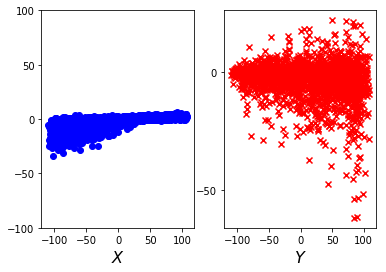

100%|██████████| 24/24 [00:00<00:00, 68.53it/s]

Epoch: 2 Train loss: 51921.4023


Test loss: 51325.9453


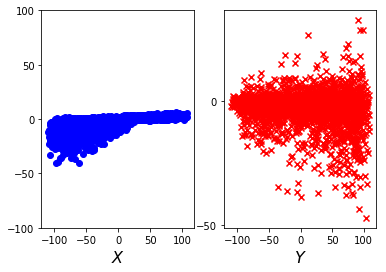

100%|██████████| 24/24 [00:00<00:00, 71.88it/s]

Epoch: 3 Train loss: 51441.3672


Test loss: 50800.1758


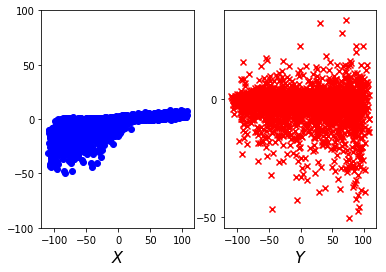

100%|██████████| 24/24 [00:00<00:00, 63.87it/s]

Epoch: 4 Train loss: 50839.8984


Test loss: 50128.1289


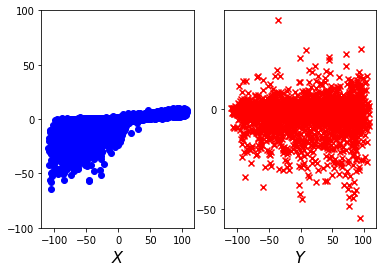

100%|██████████| 24/24 [00:00<00:00, 64.43it/s]

Epoch: 5 Train loss: 50004.0156


Test loss: 49172.9375


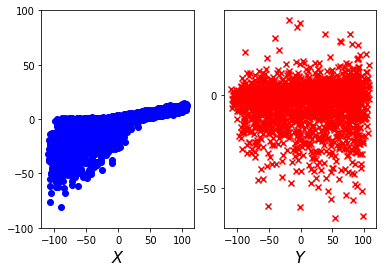

100%|██████████| 24/24 [00:00<00:00, 71.49it/s]

Epoch: 6 Train loss: 48860.2344


Test loss: 47692.8203


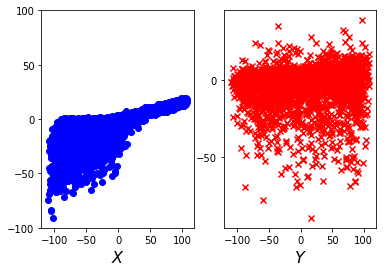

100%|██████████| 24/24 [00:00<00:00, 67.77it/s]

Epoch: 7 Train loss: 46949.0664


Test loss: 45684.1445


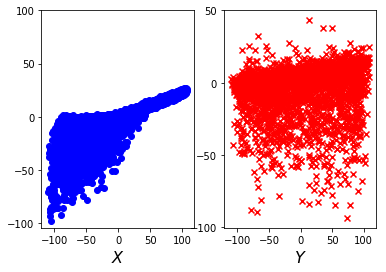

100%|██████████| 24/24 [00:00<00:00, 73.04it/s]

Epoch: 8 Train loss: 44666.3672


Test loss: 42659.7969


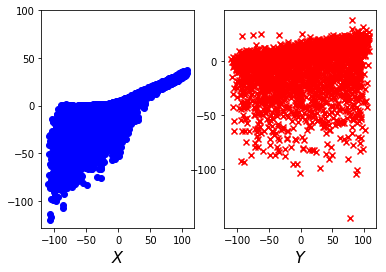

100%|██████████| 24/24 [00:00<00:00, 74.94it/s]

Epoch: 9 Train loss: 41387.1758


Test loss: 39060.4102


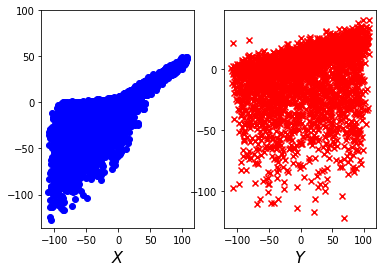

100%|██████████| 24/24 [00:00<00:00, 72.18it/s]

Epoch: 10 Train loss: 38090.6016


Test loss: 35691.2344


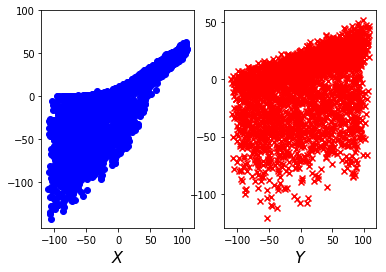

100%|██████████| 24/24 [00:00<00:00, 63.36it/s]

Epoch: 11 Train loss: 35100.3594


Test loss: 32949.9844


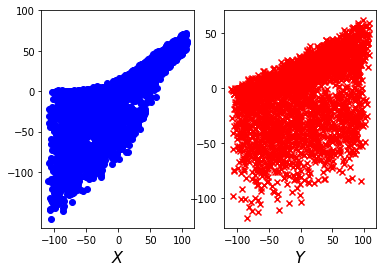

100%|██████████| 24/24 [00:00<00:00, 54.10it/s]

Epoch: 12 Train loss: 32783.1016


Test loss: 30964.4102


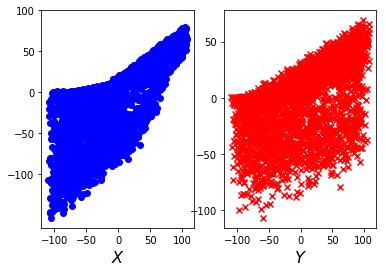

100%|██████████| 24/24 [00:00<00:00, 54.40it/s]

Epoch: 13 Train loss: 31135.5781


Test loss: 29618.0566


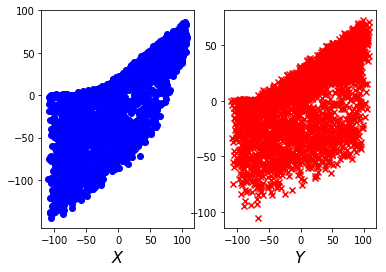

100%|██████████| 24/24 [00:00<00:00, 72.15it/s]

Epoch: 14 Train loss: 29970.5605


Test loss: 28635.4062


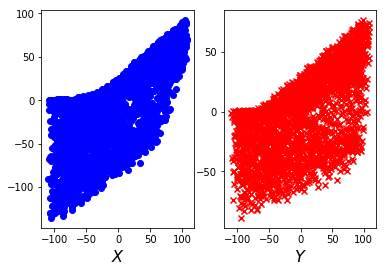

100%|██████████| 24/24 [00:00<00:00, 65.36it/s]

Epoch: 15 Train loss: 29127.6504


Test loss: 27919.5977


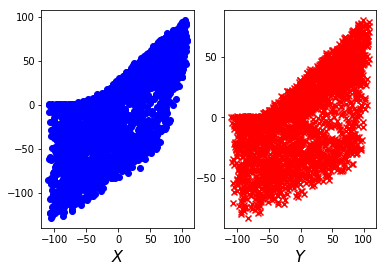

100%|██████████| 24/24 [00:00<00:00, 59.86it/s]

Epoch: 16 Train loss: 28510.3125


Test loss: 27387.4297


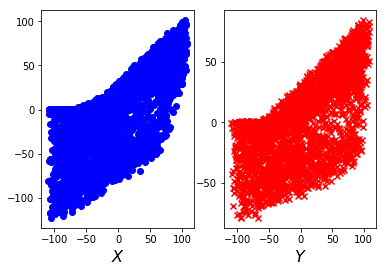

100%|██████████| 24/24 [00:00<00:00, 63.40it/s]

Epoch: 17 Train loss: 28046.0371


Test loss: 26984.6875


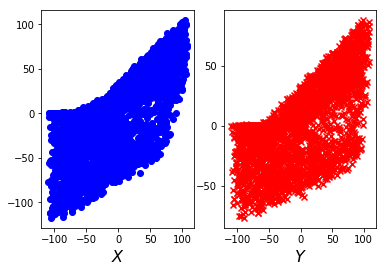

100%|██████████| 24/24 [00:00<00:00, 63.31it/s]

Epoch: 18 Train loss: 27692.1738


Test loss: 26682.0449


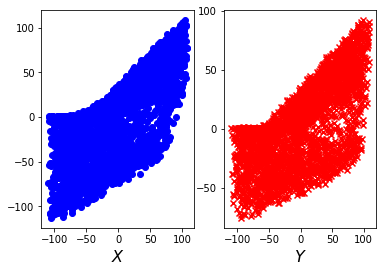

100%|██████████| 24/24 [00:00<00:00, 55.57it/s]

Epoch: 19 Train loss: 27421.5312


Test loss: 26452.8555


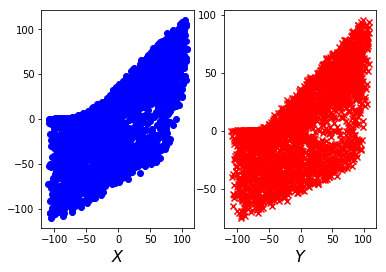

100%|██████████| 24/24 [00:00<00:00, 64.36it/s]

Epoch: 20 Train loss: 27212.2637


Test loss: 26279.3867


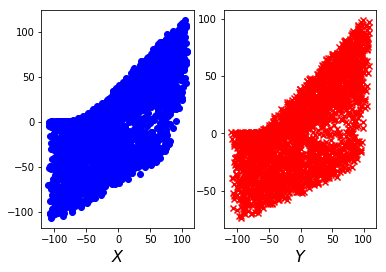

100%|██████████| 24/24 [00:00<00:00, 68.76it/s]

Epoch: 21 Train loss: 27051.1523


Test loss: 26146.2852


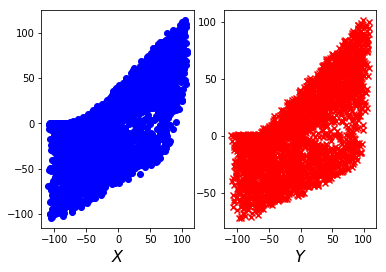

100%|██████████| 24/24 [00:00<00:00, 69.37it/s]

Epoch: 22 Train loss: 26926.5020


Test loss: 26047.2031


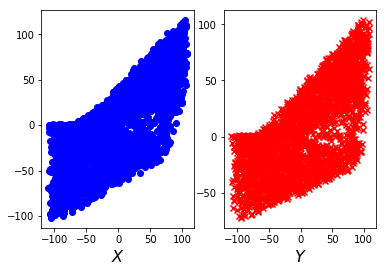

100%|██████████| 24/24 [00:00<00:00, 55.30it/s]

Epoch: 23 Train loss: 26832.1543


Test loss: 25973.0664


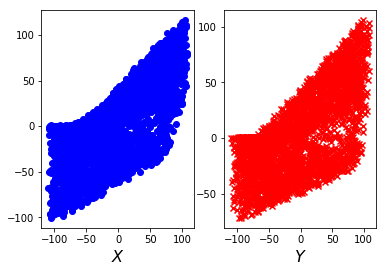

100%|██████████| 24/24 [00:00<00:00, 65.02it/s]

Epoch: 24 Train loss: 26758.5527


Test loss: 25918.9766


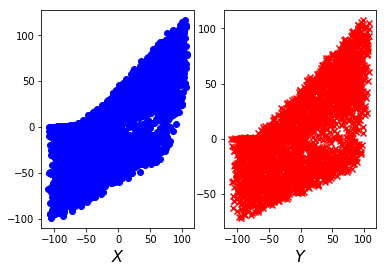

100%|██████████| 24/24 [00:00<00:00, 61.28it/s]

Epoch: 25 Train loss: 26702.2773


Test loss: 25879.1250


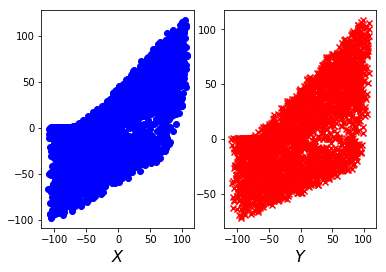

100%|██████████| 24/24 [00:00<00:00, 67.31it/s]

Epoch: 26 Train loss: 26657.9180


Test loss: 25847.8379


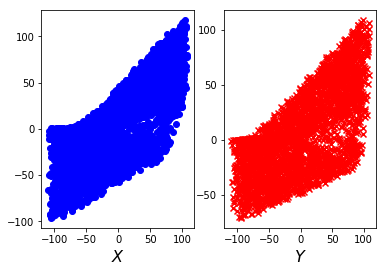

100%|██████████| 24/24 [00:00<00:00, 67.81it/s]

Epoch: 27 Train loss: 26623.8848


Test loss: 25823.9707


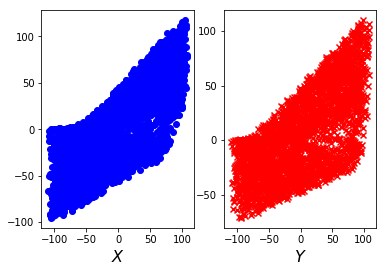

100%|██████████| 24/24 [00:00<00:00, 69.63it/s]

Epoch: 28 Train loss: 26597.8398


Test loss: 25806.0859


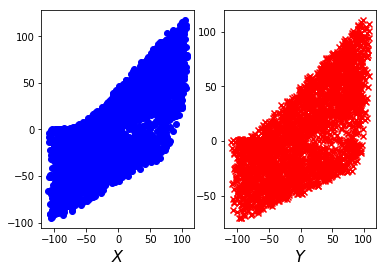

100%|██████████| 24/24 [00:00<00:00, 67.22it/s]

Epoch: 29 Train loss: 26574.6777


Test loss: 25789.8516


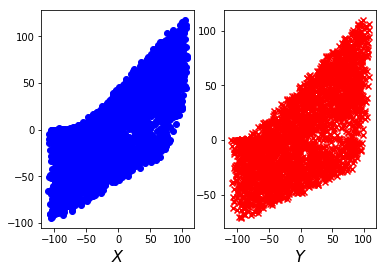

100%|██████████| 24/24 [00:00<00:00, 67.37it/s]

Epoch: 30 Train loss: 26542.2266


Test loss: 25737.6934


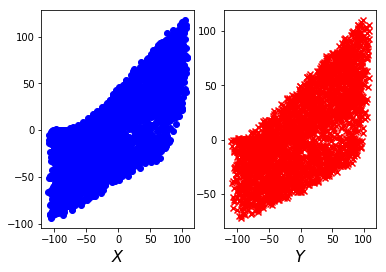

100%|██████████| 24/24 [00:00<00:00, 70.93it/s]

Epoch: 31 Train loss: 26461.4746


Test loss: 25660.0938


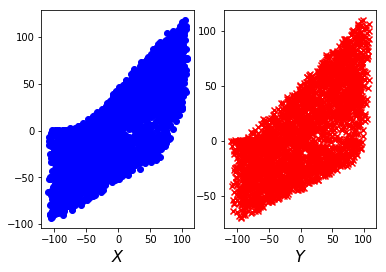

100%|██████████| 24/24 [00:00<00:00, 70.20it/s]

Epoch: 32 Train loss: 26392.6699


Test loss: 25602.0684


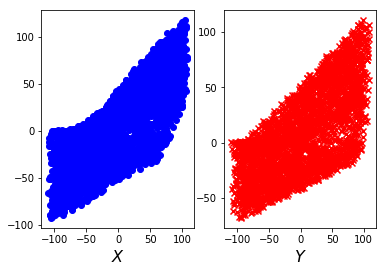

100%|██████████| 24/24 [00:00<00:00, 68.03it/s]

Epoch: 33 Train loss: 26326.2109


Test loss: 25533.2637


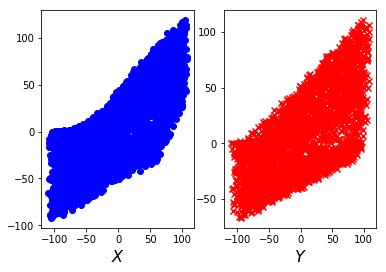

100%|██████████| 24/24 [00:00<00:00, 70.89it/s]

Epoch: 34 Train loss: 26244.2285


Test loss: 25444.4609


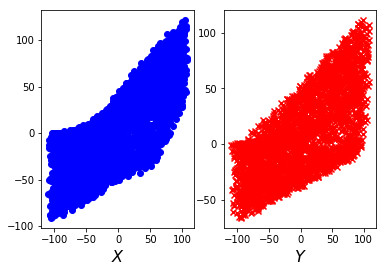

100%|██████████| 24/24 [00:00<00:00, 72.28it/s]

Epoch: 35 Train loss: 26142.2285


Test loss: 25329.3125


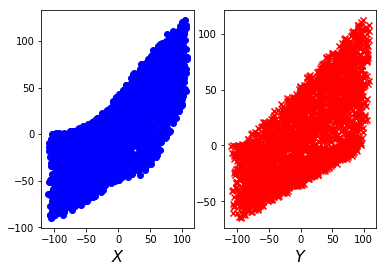

100%|██████████| 24/24 [00:00<00:00, 53.06it/s]

Epoch: 36 Train loss: 26013.7871


Test loss: 25183.8418


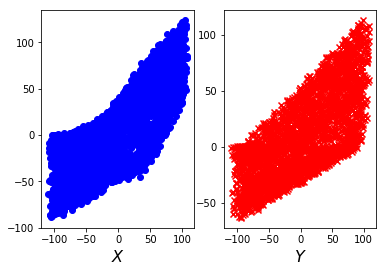

100%|██████████| 24/24 [00:00<00:00, 71.65it/s]

Epoch: 37 Train loss: 25851.3066


Test loss: 25005.7871


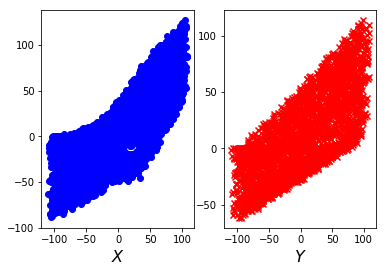

100%|██████████| 24/24 [00:00<00:00, 65.23it/s]

Epoch: 38 Train loss: 25655.9219


Test loss: 24795.6504


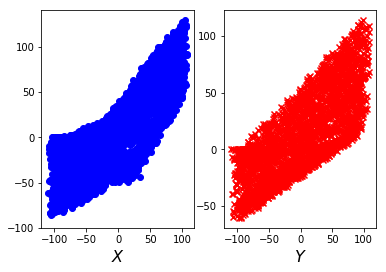

100%|██████████| 24/24 [00:00<00:00, 65.58it/s]

Epoch: 39 Train loss: 25436.6348


Test loss: 24553.7715


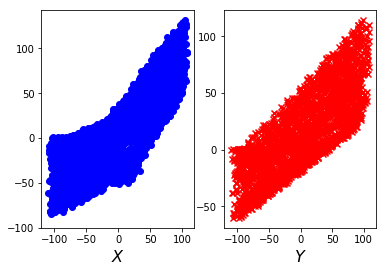

100%|██████████| 24/24 [00:00<00:00, 61.61it/s]

Epoch: 40 Train loss: 25190.7598


Test loss: 24293.5176


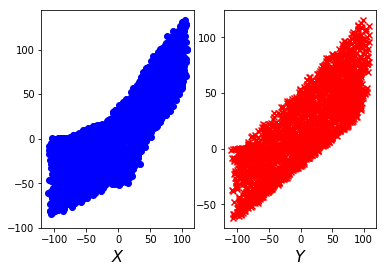

100%|██████████| 24/24 [00:00<00:00, 69.91it/s]

Epoch: 41 Train loss: 24935.0078


Test loss: 24030.5332


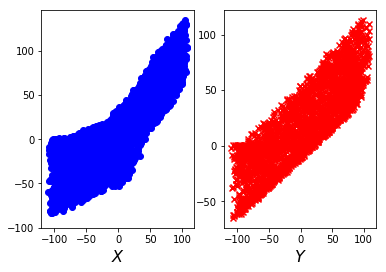

100%|██████████| 24/24 [00:00<00:00, 66.53it/s]

Epoch: 42 Train loss: 24682.9121


Test loss: 23779.5742


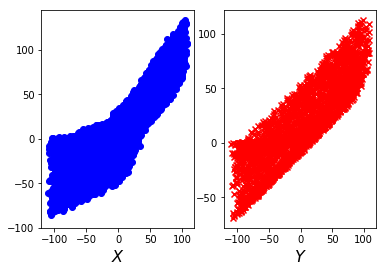

100%|██████████| 24/24 [00:00<00:00, 70.24it/s]

Epoch: 43 Train loss: 24444.5547


Test loss: 23546.2266


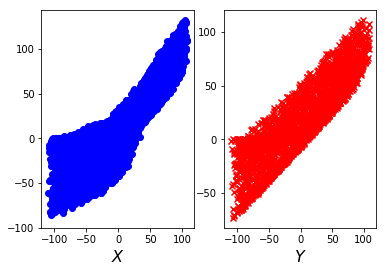

100%|██████████| 24/24 [00:00<00:00, 64.18it/s]

Epoch: 44 Train loss: 24221.2168


Test loss: 23331.3711


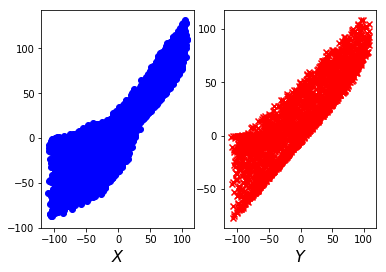

100%|██████████| 24/24 [00:00<00:00, 69.82it/s]

Epoch: 45 Train loss: 24014.6836


Test loss: 23133.5469


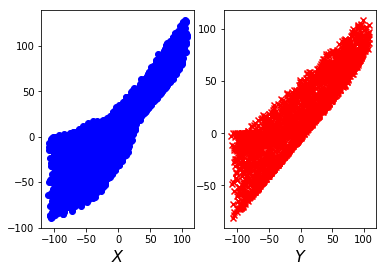

100%|██████████| 24/24 [00:00<00:00, 59.37it/s]

Epoch: 46 Train loss: 23826.1543


Test loss: 22955.5684


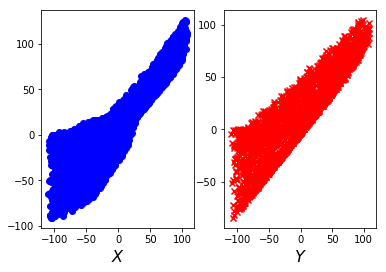

100%|██████████| 24/24 [00:00<00:00, 58.03it/s]

Epoch: 47 Train loss: 23652.1172


Test loss: 22791.8164


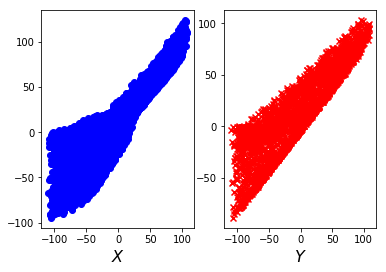

100%|██████████| 24/24 [00:00<00:00, 55.70it/s]

Epoch: 48 Train loss: 23492.1328


Test loss: 22644.1328


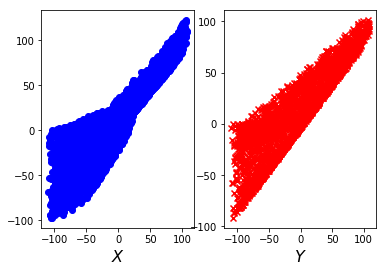

100%|██████████| 24/24 [00:00<00:00, 62.13it/s]

Epoch: 49 Train loss: 23342.7578


Test loss: 22506.0586


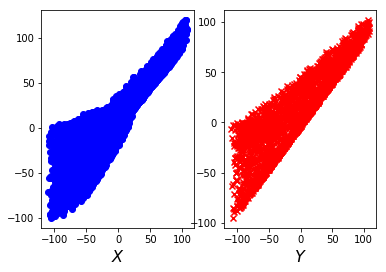

100%|██████████| 24/24 [00:00<00:00, 59.27it/s]

Epoch: 50 Train loss: 23204.3281


Test loss: 22382.6191


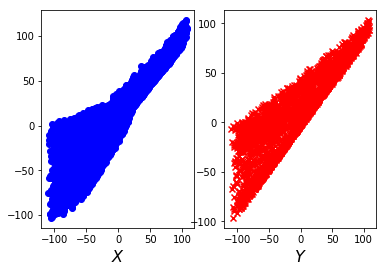

100%|██████████| 24/24 [00:00<00:00, 69.13it/s]

Epoch: 51 Train loss: 23079.1172


Test loss: 22269.8594


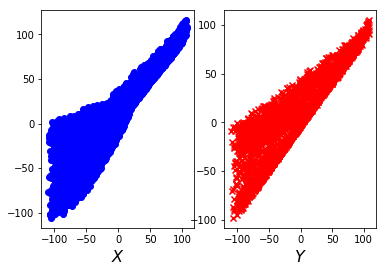

100%|██████████| 24/24 [00:00<00:00, 65.53it/s]

Epoch: 52 Train loss: 22963.4023


Test loss: 22169.5547


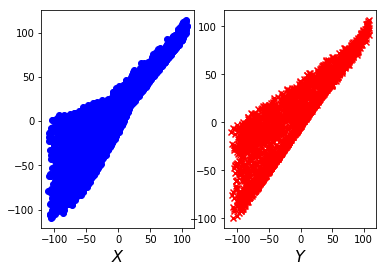

100%|██████████| 24/24 [00:00<00:00, 68.04it/s]

Epoch: 53 Train loss: 22857.3145


Test loss: 22077.3711


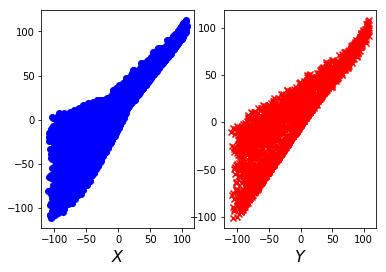

100%|██████████| 24/24 [00:02<00:00, 10.98it/s]

Epoch: 54 Train loss: 22759.4648


Test loss: 21992.5312


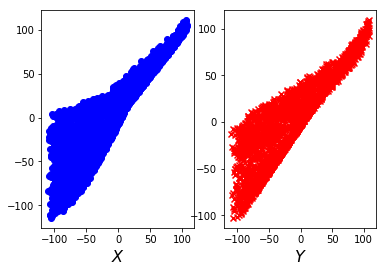

100%|██████████| 24/24 [00:00<00:00, 64.28it/s]

Epoch: 55 Train loss: 22666.7070


Test loss: 21913.3633


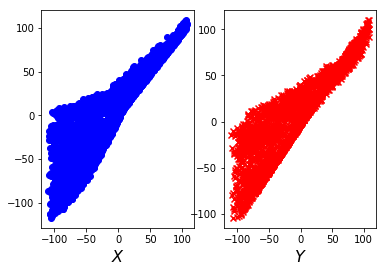

100%|██████████| 24/24 [00:00<00:00, 74.86it/s]

Epoch: 56 Train loss: 22577.6074


Test loss: 21815.5586


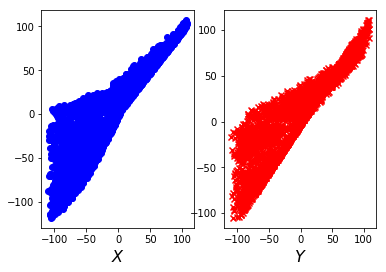

100%|██████████| 24/24 [00:00<00:00, 83.11it/s]

Epoch: 57 Train loss: 22339.3516


Test loss: 21528.5527


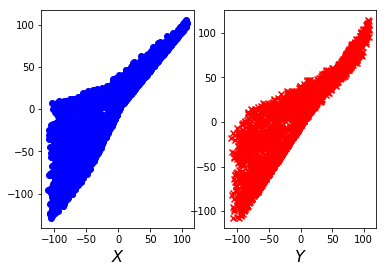

100%|██████████| 24/24 [00:00<00:00, 85.66it/s]

Epoch: 58 Train loss: 22024.0566


Test loss: 21238.5898


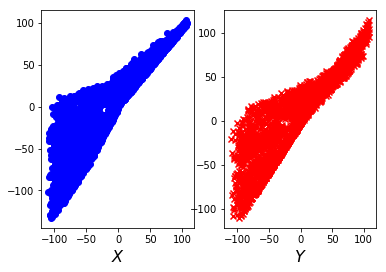

100%|██████████| 24/24 [00:00<00:00, 76.16it/s]

Epoch: 59 Train loss: 21613.8574


Test loss: 20738.3359


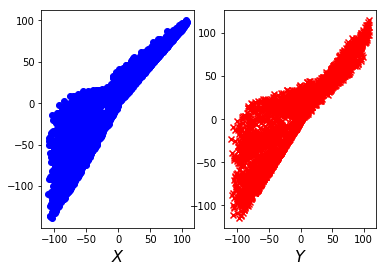

100%|██████████| 24/24 [00:00<00:00, 88.66it/s]

Epoch: 60 Train loss: 20743.7031


Test loss: 19542.6465


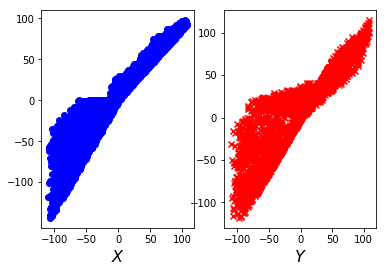

100%|██████████| 24/24 [00:00<00:00, 87.34it/s]

Epoch: 61 Train loss: 18706.8027


Test loss: 16869.7520


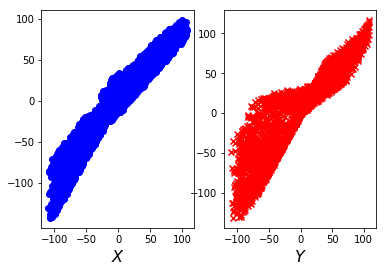

100%|██████████| 24/24 [00:00<00:00, 74.10it/s]

Epoch: 62 Train loss: 15304.3760


Test loss: 13328.6084


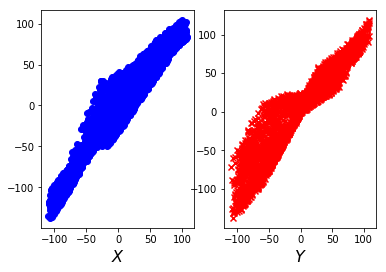

100%|██████████| 24/24 [00:00<00:00, 88.06it/s]

Epoch: 63 Train loss: 12290.6055


Test loss: 11229.1973


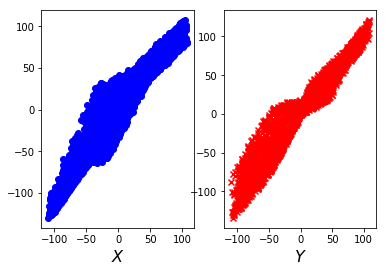

100%|██████████| 24/24 [00:00<00:00, 76.58it/s]

Epoch: 64 Train loss: 10765.9453


Test loss: 10170.8760


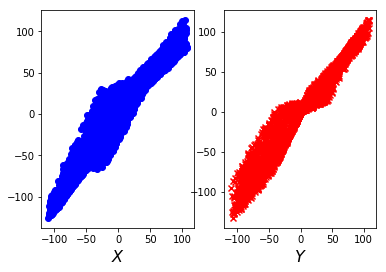

100%|██████████| 24/24 [00:00<00:00, 75.04it/s]

Epoch: 65 Train loss: 9826.1377


Test loss: 9389.5098


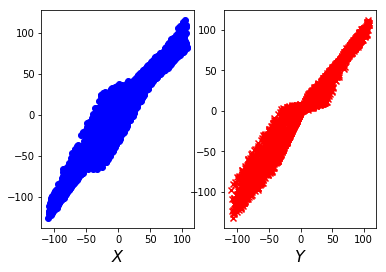

100%|██████████| 24/24 [00:00<00:00, 74.99it/s]

Epoch: 66 Train loss: 8954.6885


Test loss: 8447.2598


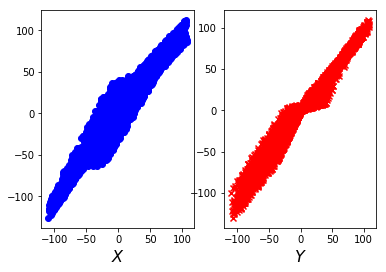

100%|██████████| 24/24 [00:00<00:00, 76.62it/s]

Epoch: 67 Train loss: 7710.3672


Test loss: 6791.4751


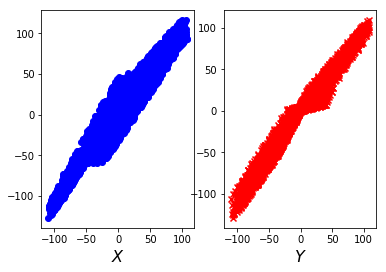

100%|██████████| 24/24 [00:00<00:00, 81.19it/s]

Epoch: 68 Train loss: 5580.9146


Test loss: 4268.1724


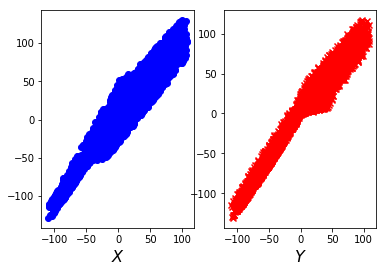

100%|██████████| 24/24 [00:00<00:00, 81.04it/s]

Epoch: 69 Train loss: 3206.6716


Test loss: 2477.2629


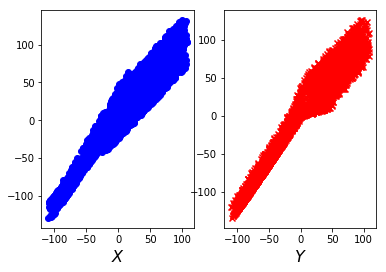

100%|██████████| 24/24 [00:00<00:00, 74.12it/s]

Epoch: 70 Train loss: 2048.4570


Test loss: 1752.0713


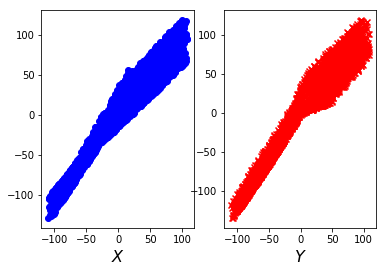

100%|██████████| 24/24 [00:00<00:00, 85.09it/s]

Epoch: 71 Train loss: 1557.6359


Test loss: 1414.0920


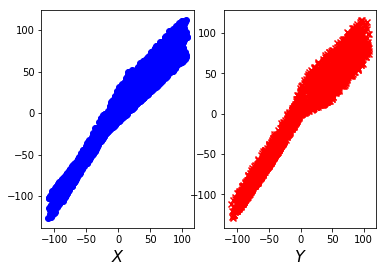

100%|██████████| 24/24 [00:00<00:00, 72.62it/s]

Epoch: 72 Train loss: 1305.9691


Test loss: 1218.1669


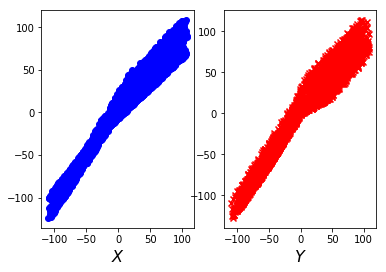

100%|██████████| 24/24 [00:00<00:00, 77.55it/s]

Epoch: 73 Train loss: 1143.9087


Test loss: 1077.2329


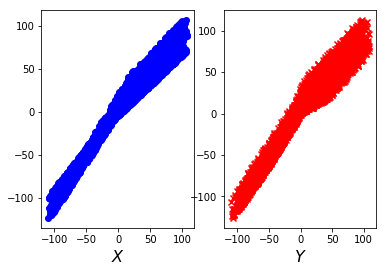

100%|██████████| 24/24 [00:00<00:00, 72.01it/s]

Epoch: 74 Train loss: 1017.2469


Test loss: 963.0652


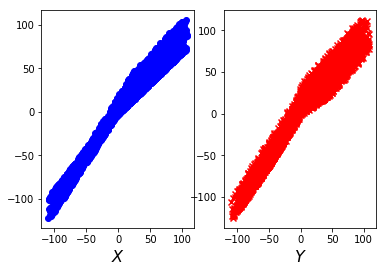

100%|██████████| 24/24 [00:00<00:00, 80.02it/s]

Epoch: 75 Train loss: 912.0379


Test loss: 864.1286


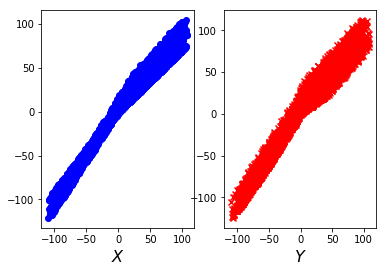

100%|██████████| 24/24 [00:00<00:00, 73.65it/s]

Epoch: 76 Train loss: 822.7573


Test loss: 779.5967


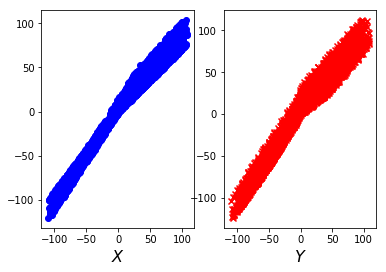

100%|██████████| 24/24 [00:00<00:00, 43.57it/s]

Epoch: 77 Train loss: 745.7449


Test loss: 707.4621


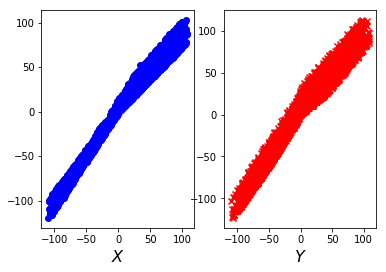

100%|██████████| 24/24 [00:00<00:00, 46.29it/s]

Epoch: 78 Train loss: 677.4283


Test loss: 640.5539


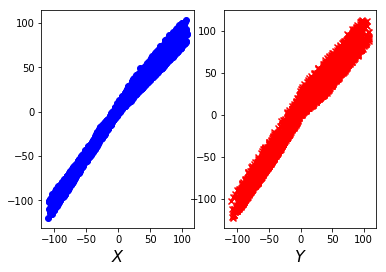

100%|██████████| 24/24 [00:00<00:00, 71.64it/s]

Epoch: 79 Train loss: 614.9155


Test loss: 578.2025


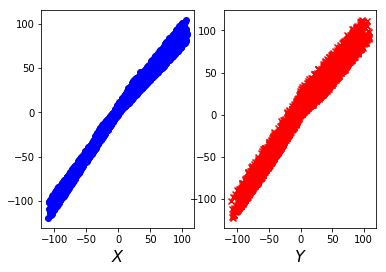

100%|██████████| 24/24 [00:00<00:00, 84.29it/s]

Epoch: 80 Train loss: 560.8056


Test loss: 527.3560


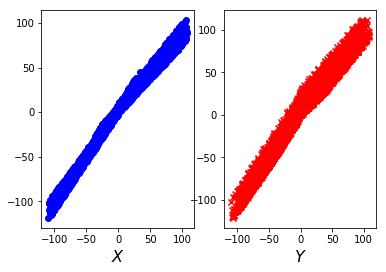

100%|██████████| 24/24 [00:00<00:00, 68.81it/s]

Epoch: 81 Train loss: 514.9508


Test loss: 485.6010


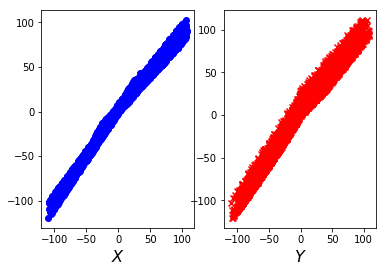

100%|██████████| 24/24 [00:00<00:00, 83.91it/s]

Epoch: 82 Train loss: 474.8815


Test loss: 448.5247


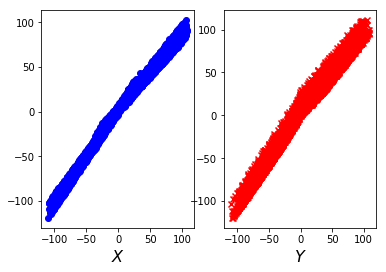

100%|██████████| 24/24 [00:00<00:00, 72.82it/s]

Epoch: 83 Train loss: 439.0771


Test loss: 415.8471


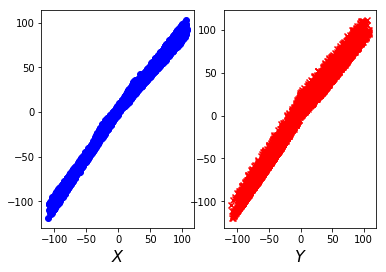

100%|██████████| 24/24 [00:00<00:00, 76.86it/s]

Epoch: 84 Train loss: 405.9802


Test loss: 385.3672


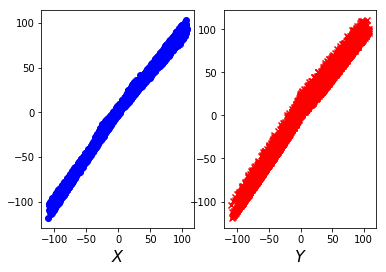

100%|██████████| 24/24 [00:00<00:00, 75.95it/s]

Epoch: 85 Train loss: 377.9196


Test loss: 359.1948


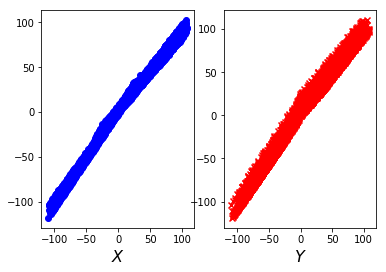

100%|██████████| 24/24 [00:00<00:00, 71.95it/s]

Epoch: 86 Train loss: 353.0798


Test loss: 336.6504


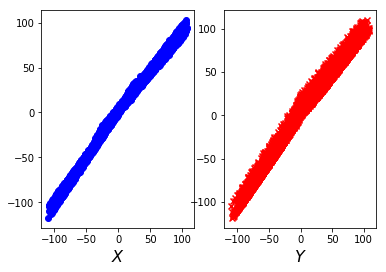

100%|██████████| 24/24 [00:00<00:00, 31.57it/s]

Epoch: 87 Train loss: 330.1850


Test loss: 315.7105


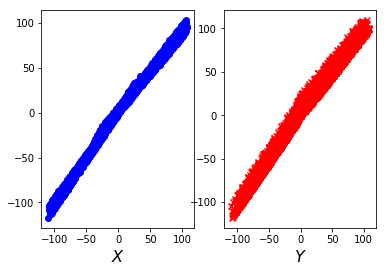

100%|██████████| 24/24 [00:00<00:00, 80.36it/s]


Epoch: 88 Train loss: 309.7543
Test loss: 296.8616


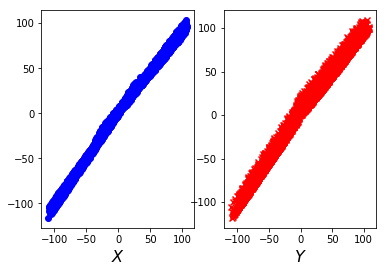

100%|██████████| 24/24 [00:00<00:00, 80.95it/s]

Epoch: 89 Train loss: 293.3389


Test loss: 280.9422


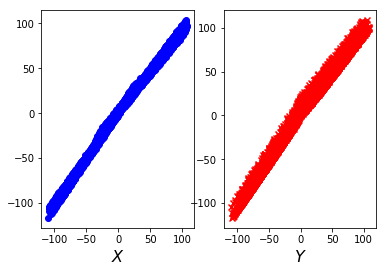

100%|██████████| 24/24 [00:00<00:00, 81.40it/s]

Epoch: 90 Train loss: 275.8517


Test loss: 265.8402


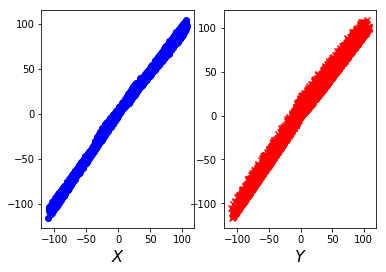

100%|██████████| 24/24 [00:00<00:00, 74.50it/s]

Epoch: 91 Train loss: 260.1840


Test loss: 250.7301


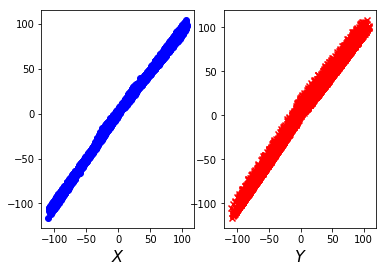

100%|██████████| 24/24 [00:00<00:00, 73.23it/s]

Epoch: 92 Train loss: 246.0103


Test loss: 237.5211


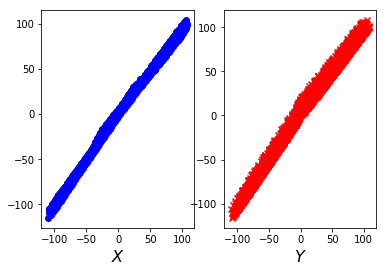

100%|██████████| 24/24 [00:00<00:00, 73.90it/s]

Epoch: 93 Train loss: 233.1594


Test loss: 225.0184


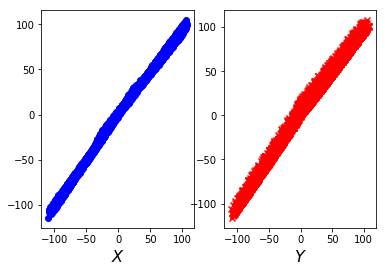

100%|██████████| 24/24 [00:00<00:00, 74.51it/s]

Epoch: 94 Train loss: 220.3820


Test loss: 213.0822


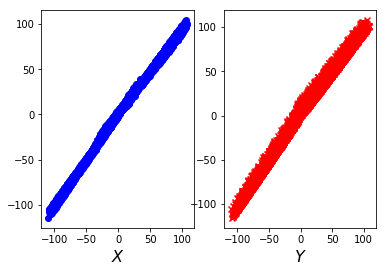

100%|██████████| 24/24 [00:00<00:00, 75.66it/s]

Epoch: 95 Train loss: 208.8668


Test loss: 201.8622


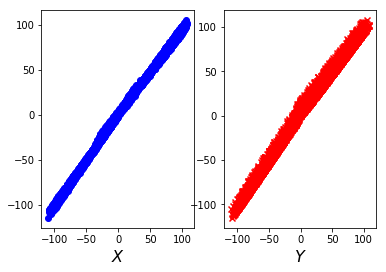

100%|██████████| 24/24 [00:00<00:00, 76.66it/s]

Epoch: 96 Train loss: 197.4670


Test loss: 191.4636


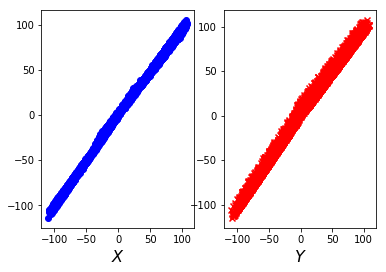

100%|██████████| 24/24 [00:00<00:00, 76.90it/s]

Epoch: 97 Train loss: 187.0886


Test loss: 181.8809


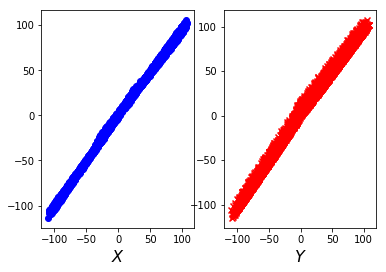

100%|██████████| 24/24 [00:00<00:00, 81.57it/s]

Epoch: 98 Train loss: 178.7499


Test loss: 171.9495


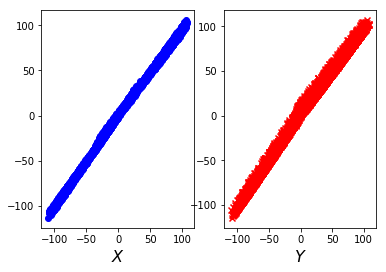

100%|██████████| 24/24 [00:00<00:00, 79.41it/s]


Epoch: 99 Train loss: 169.2606
Test loss: 163.0265


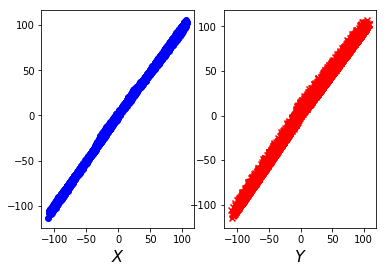

100%|██████████| 24/24 [00:00<00:00, 78.64it/s]


Epoch: 100 Train loss: 160.5041
Test loss: 154.2287


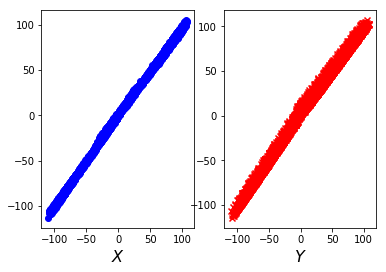

100%|██████████| 24/24 [00:00<00:00, 82.96it/s]

Epoch: 101 Train loss: 152.5316


Test loss: 145.9970


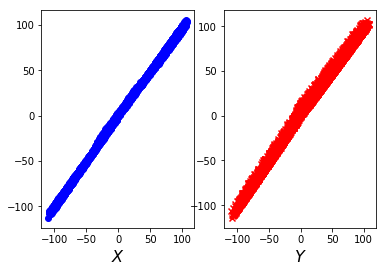

100%|██████████| 24/24 [00:00<00:00, 76.18it/s]

Epoch: 102 Train loss: 144.6410


Test loss: 137.9920


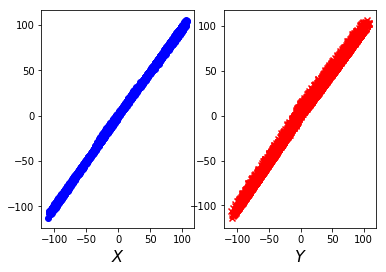

100%|██████████| 24/24 [00:00<00:00, 78.46it/s]


Epoch: 103 Train loss: 136.9850
Test loss: 130.6174


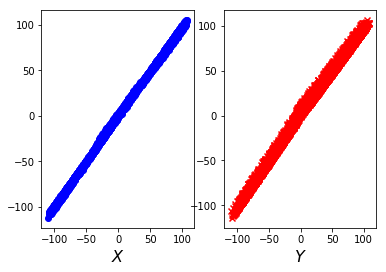

100%|██████████| 24/24 [00:00<00:00, 77.13it/s]

Epoch: 104 Train loss: 129.5118


Test loss: 123.8973


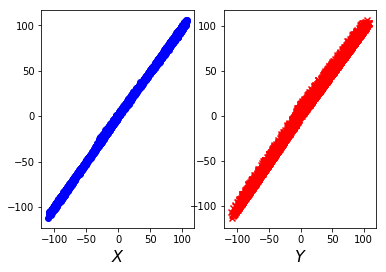

100%|██████████| 24/24 [00:00<00:00, 83.06it/s]

Epoch: 105 Train loss: 122.6513


Test loss: 116.8745


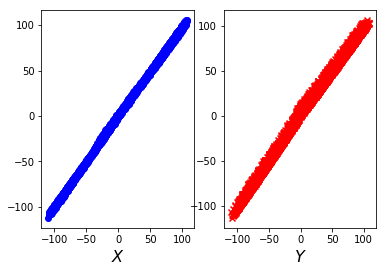

100%|██████████| 24/24 [00:00<00:00, 79.08it/s]

Epoch: 106 Train loss: 116.0878


Test loss: 111.1191


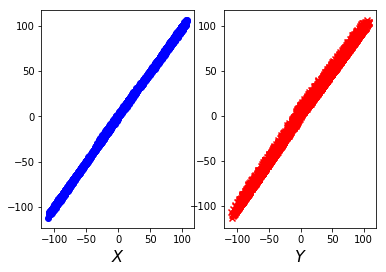

100%|██████████| 24/24 [00:00<00:00, 39.02it/s]

Epoch: 107 Train loss: 109.9309


Test loss: 105.4145


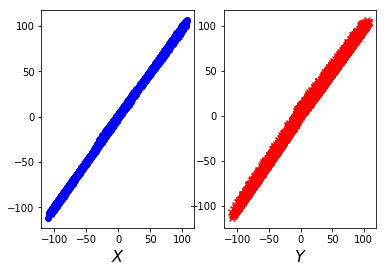

100%|██████████| 24/24 [00:00<00:00, 38.59it/s]

Epoch: 108 Train loss: 104.2458


Test loss: 99.9418


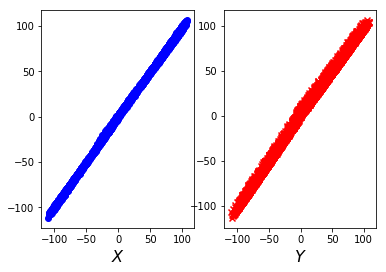

100%|██████████| 24/24 [00:00<00:00, 79.03it/s]

Epoch: 109 Train loss: 98.4917


Test loss: 94.3782


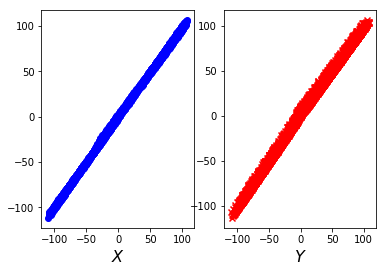

100%|██████████| 24/24 [00:00<00:00, 71.02it/s]

Epoch: 110 Train loss: 93.9495


Test loss: 89.5659


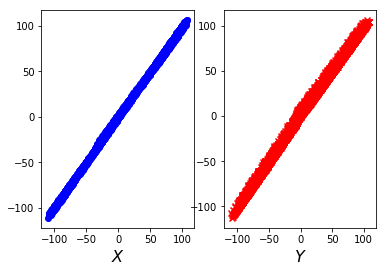

100%|██████████| 24/24 [00:00<00:00, 80.71it/s]


Epoch: 111 Train loss: 88.9696
Test loss: 84.8330


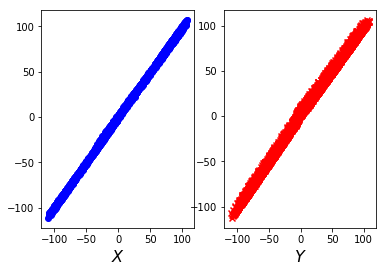

100%|██████████| 24/24 [00:00<00:00, 68.90it/s]

Epoch: 112 Train loss: 85.0717


Test loss: 80.6408


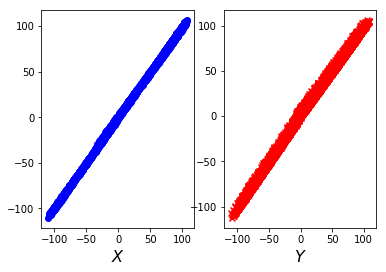

100%|██████████| 24/24 [00:00<00:00, 71.71it/s]

Epoch: 113 Train loss: 80.5566


Test loss: 77.0997


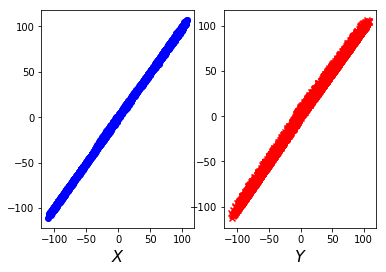

100%|██████████| 24/24 [00:00<00:00, 76.66it/s]

Epoch: 114 Train loss: 76.5253


Test loss: 73.4884


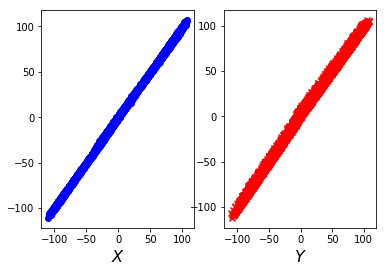

100%|██████████| 24/24 [00:00<00:00, 74.04it/s]

Epoch: 115 Train loss: 72.6090


Test loss: 69.5933


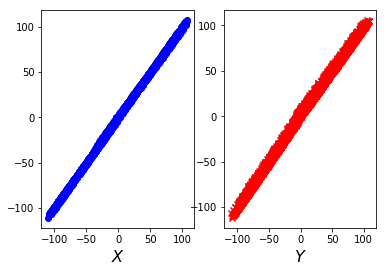

100%|██████████| 24/24 [00:00<00:00, 75.60it/s]

Epoch: 116 Train loss: 69.4821


Test loss: 66.2915


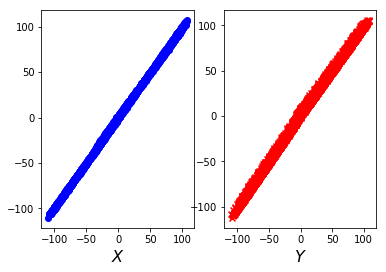

100%|██████████| 24/24 [00:00<00:00, 78.52it/s]


Epoch: 117 Train loss: 66.4636
Test loss: 63.5390


100%|██████████| 24/24 [00:00<00:00, 73.70it/s]

Epoch: 118 Train loss: 62.8880


Test loss: 60.4531


100%|██████████| 24/24 [00:00<00:00, 77.42it/s]

Epoch: 119 Train loss: 59.9377


Test loss: 57.9251


100%|██████████| 24/24 [00:00<00:00, 78.09it/s]

Epoch: 120 Train loss: 57.3563


Test loss: 54.9184


100%|██████████| 24/24 [00:00<00:00, 74.31it/s]

Epoch: 121 Train loss: 54.8727


Test loss: 52.7059


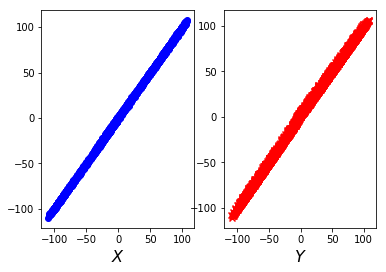

100%|██████████| 24/24 [00:00<00:00, 43.85it/s]

Epoch: 122 Train loss: 51.9542


Test loss: 50.0362


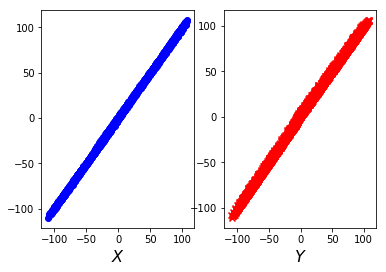

100%|██████████| 24/24 [00:00<00:00, 75.00it/s]

Epoch: 123 Train loss: 49.8129


Test loss: 47.7971


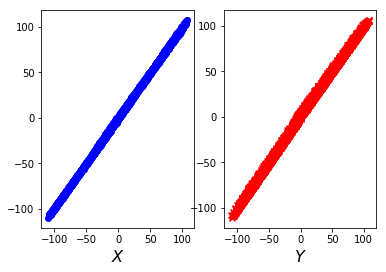

100%|██████████| 24/24 [00:00<00:00, 72.92it/s]

Epoch: 124 Train loss: 47.5782


Test loss: 45.7702


100%|██████████| 24/24 [00:00<00:00, 77.11it/s]

Epoch: 125 Train loss: 45.4208


Test loss: 43.9296


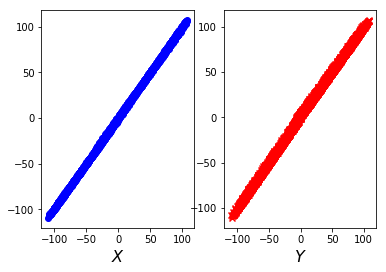

100%|██████████| 24/24 [00:00<00:00, 63.59it/s]

Epoch: 126 Train loss: 43.3287


Test loss: 41.9561


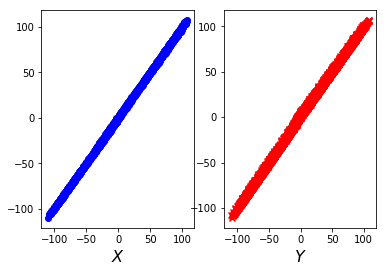

100%|██████████| 24/24 [00:00<00:00, 68.62it/s]

Epoch: 127 Train loss: 41.6134


Test loss: 40.2816


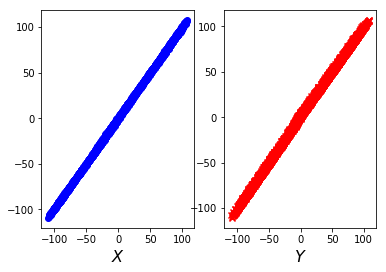

100%|██████████| 24/24 [00:00<00:00, 68.15it/s]

Epoch: 128 Train loss: 39.5661


Test loss: 38.4500


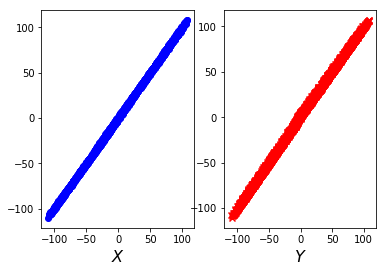

100%|██████████| 24/24 [00:00<00:00, 75.04it/s]

Epoch: 129 Train loss: 37.9238


Test loss: 36.9321


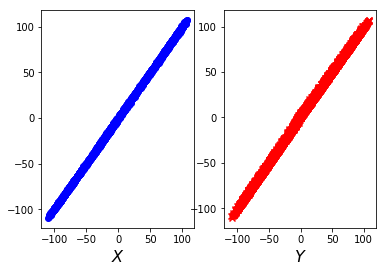

100%|██████████| 24/24 [00:00<00:00, 44.36it/s]

Epoch: 130 Train loss: 36.4346


Test loss: 35.2749


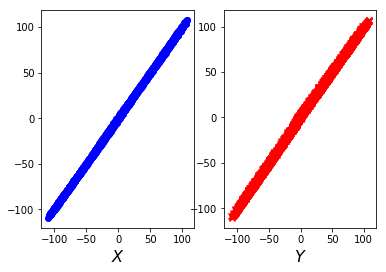

100%|██████████| 24/24 [00:00<00:00, 74.22it/s]

Epoch: 131 Train loss: 35.0296


Test loss: 33.6866


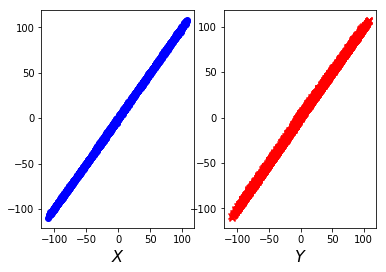

100%|██████████| 24/24 [00:00<00:00, 74.03it/s]

Epoch: 132 Train loss: 33.3939


Test loss: 32.6226


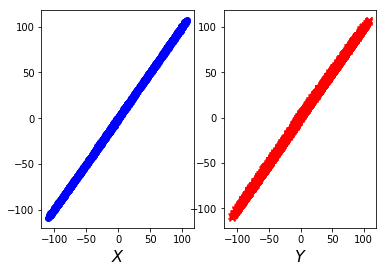

100%|██████████| 24/24 [00:00<00:00, 76.15it/s]

Epoch: 133 Train loss: 32.2515


Test loss: 31.4085


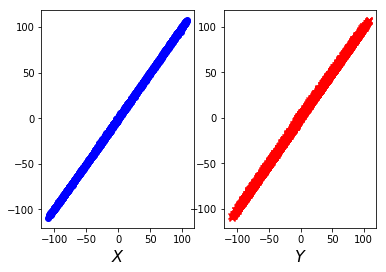

100%|██████████| 24/24 [00:00<00:00, 65.56it/s]

Epoch: 134 Train loss: 31.1174


Test loss: 29.8852


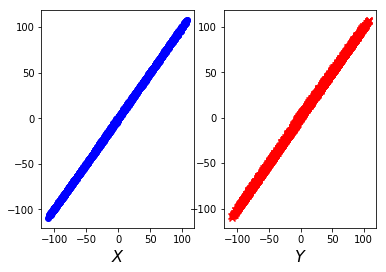

100%|██████████| 24/24 [00:00<00:00, 71.92it/s]

Epoch: 135 Train loss: 29.8757


Test loss: 28.7920


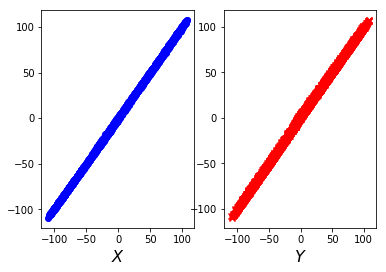

100%|██████████| 24/24 [00:00<00:00, 75.82it/s]

Epoch: 136 Train loss: 28.5303


Test loss: 27.2997


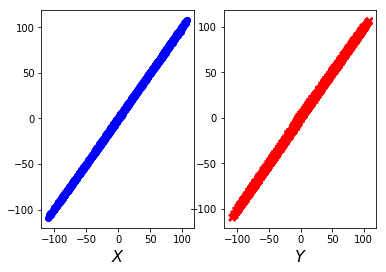

100%|██████████| 24/24 [00:00<00:00, 70.08it/s]

Epoch: 137 Train loss: 27.3875


Test loss: 26.4885


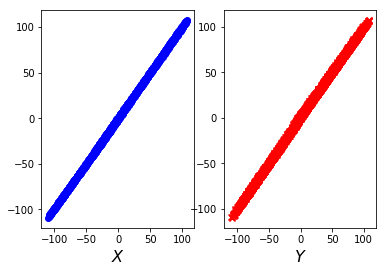

100%|██████████| 24/24 [00:00<00:00, 73.29it/s]

Epoch: 138 Train loss: 26.3222


Test loss: 25.1041


100%|██████████| 24/24 [00:00<00:00, 76.27it/s]

Epoch: 139 Train loss: 25.2090


Test loss: 24.5570


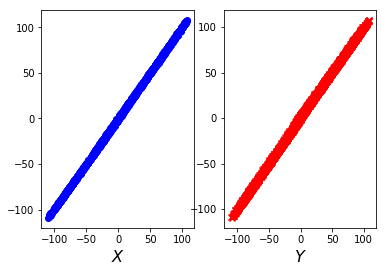

100%|██████████| 24/24 [00:00<00:00, 73.31it/s]

Epoch: 140 Train loss: 24.1297


Test loss: 23.3335


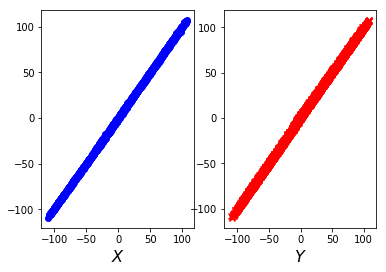

100%|██████████| 24/24 [00:00<00:00, 32.58it/s]

Epoch: 141 Train loss: 23.1718


Test loss: 22.4728


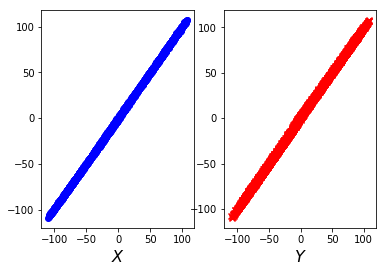

100%|██████████| 24/24 [00:00<00:00, 72.82it/s]

Epoch: 142 Train loss: 22.3552


Test loss: 21.5913


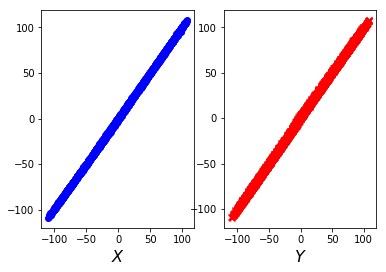

100%|██████████| 24/24 [00:00<00:00, 66.94it/s]

Epoch: 143 Train loss: 21.3039


Test loss: 20.6679


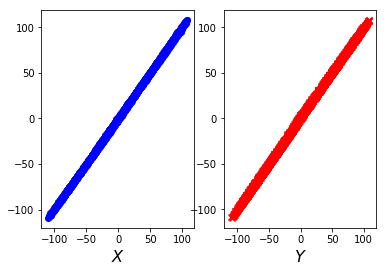

100%|██████████| 24/24 [00:00<00:00, 31.35it/s]

Epoch: 144 Train loss: 20.3270


Test loss: 19.8474


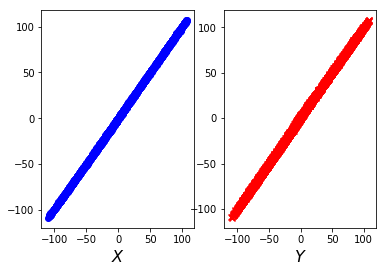

100%|██████████| 24/24 [00:00<00:00, 35.19it/s]

Epoch: 145 Train loss: 19.4129


Test loss: 18.9595


100%|██████████| 24/24 [00:00<00:00, 71.99it/s]

Epoch: 146 Train loss: 18.9472


Test loss: 17.9211


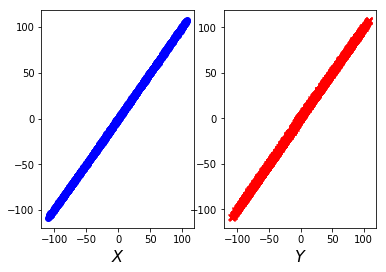

100%|██████████| 24/24 [00:00<00:00, 65.70it/s]

Epoch: 147 Train loss: 18.0464


Test loss: 17.3064


100%|██████████| 24/24 [00:00<00:00, 60.92it/s]

Epoch: 148 Train loss: 17.1980


Test loss: 16.8434


100%|██████████| 24/24 [00:00<00:00, 46.13it/s]

Epoch: 149 Train loss: 16.5548


Test loss: 15.8556


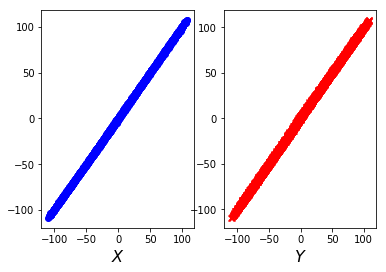

100%|██████████| 24/24 [00:00<00:00, 69.00it/s]

Epoch: 150 Train loss: 15.9233


Test loss: 15.2771


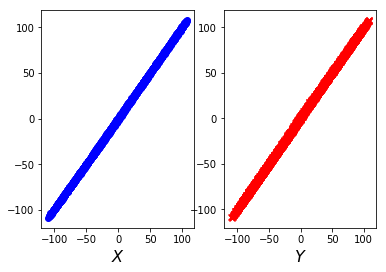

100%|██████████| 24/24 [00:00<00:00, 73.27it/s]

Epoch: 151 Train loss: 15.4117


Test loss: 14.7539


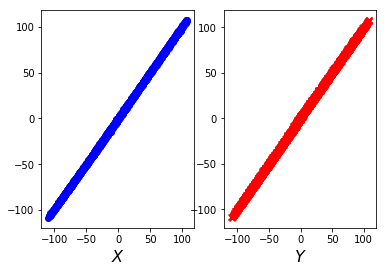

100%|██████████| 24/24 [00:00<00:00, 73.63it/s]

Epoch: 152 Train loss: 14.8489


Test loss: 14.0547


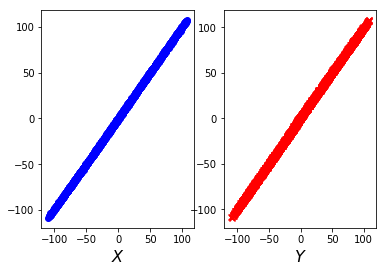

100%|██████████| 24/24 [00:00<00:00, 70.32it/s]

Epoch: 153 Train loss: 14.3276


Test loss: 13.8350


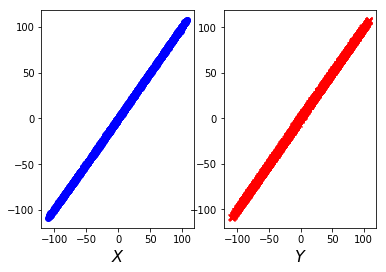

100%|██████████| 24/24 [00:00<00:00, 45.01it/s]

Epoch: 154 Train loss: 13.8091


Test loss: 13.2569


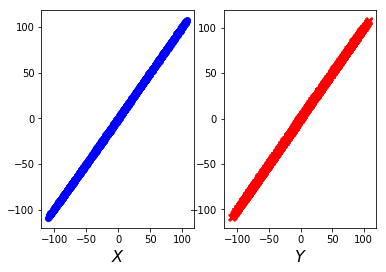

100%|██████████| 24/24 [00:00<00:00, 68.41it/s]

Epoch: 155 Train loss: 13.2110


Test loss: 12.8714


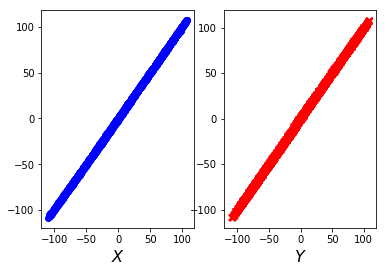

100%|██████████| 24/24 [00:00<00:00, 68.79it/s]

Epoch: 156 Train loss: 12.8779


Test loss: 12.4277


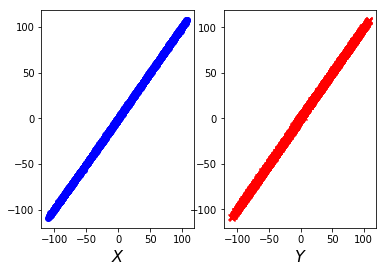

100%|██████████| 24/24 [00:00<00:00, 69.94it/s]

Epoch: 157 Train loss: 12.5591


Test loss: 11.9103


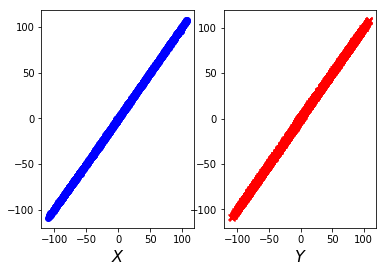

100%|██████████| 24/24 [00:00<00:00, 71.82it/s]

Epoch: 158 Train loss: 12.1762


Test loss: 11.6560


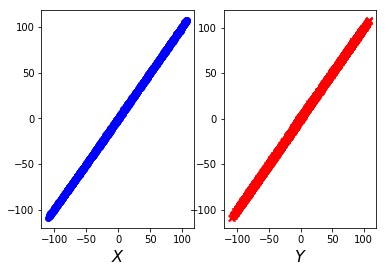

100%|██████████| 24/24 [00:00<00:00, 42.48it/s]

Epoch: 159 Train loss: 11.7675


Test loss: 11.2782


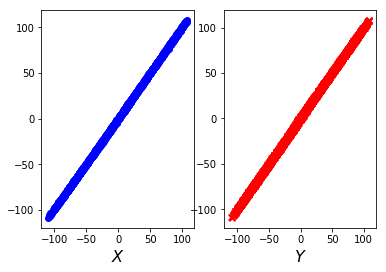

100%|██████████| 24/24 [00:00<00:00, 72.65it/s]

Epoch: 160 Train loss: 11.3843


Test loss: 10.8531


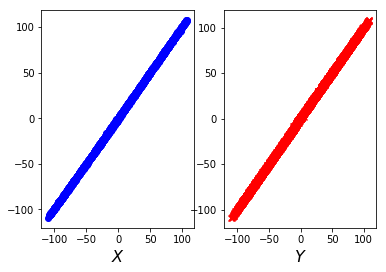

100%|██████████| 24/24 [00:00<00:00, 71.73it/s]

Epoch: 161 Train loss: 11.0252


Test loss: 10.7786


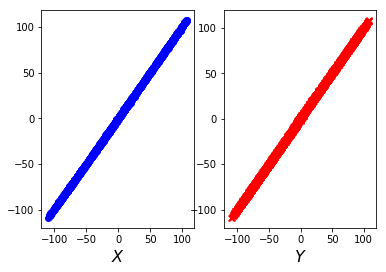

100%|██████████| 24/24 [00:00<00:00, 74.57it/s]

Epoch: 162 Train loss: 10.6238


Test loss: 10.3252


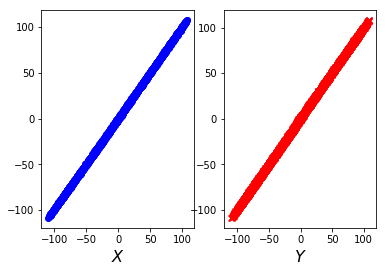

100%|██████████| 24/24 [00:00<00:00, 75.33it/s]

Epoch: 163 Train loss: 10.5667


Test loss: 9.9562


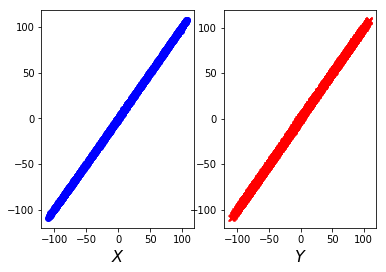

100%|██████████| 24/24 [00:00<00:00, 75.48it/s]

Epoch: 164 Train loss: 10.2665


Test loss: 9.8389


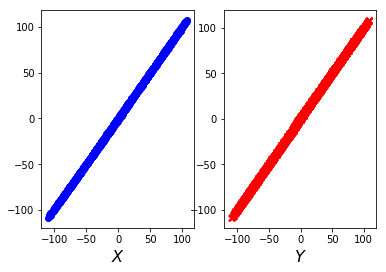

100%|██████████| 24/24 [00:00<00:00, 70.51it/s]

Epoch: 165 Train loss: 10.0167


Test loss: 9.5756


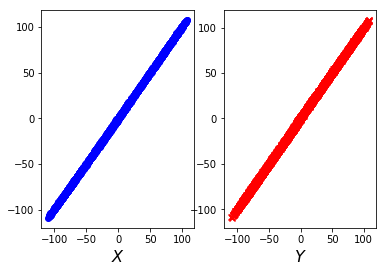

100%|██████████| 24/24 [00:00<00:00, 73.97it/s]

Epoch: 166 Train loss: 9.7712


Test loss: 9.3013


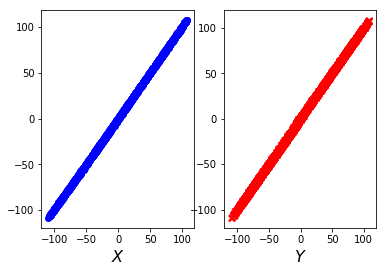

100%|██████████| 24/24 [00:00<00:00, 44.93it/s]

Epoch: 167 Train loss: 9.4610


Test loss: 9.2433


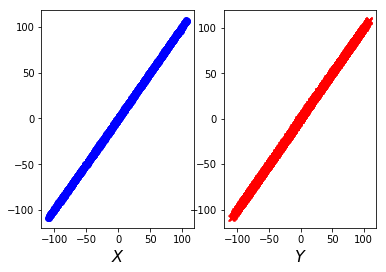

100%|██████████| 24/24 [00:00<00:00, 71.49it/s]

Epoch: 168 Train loss: 9.4067


Test loss: 8.9043


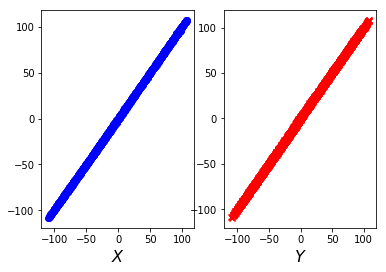

100%|██████████| 24/24 [00:00<00:00, 46.63it/s]

Epoch: 169 Train loss: 9.1381


Test loss: 8.6518


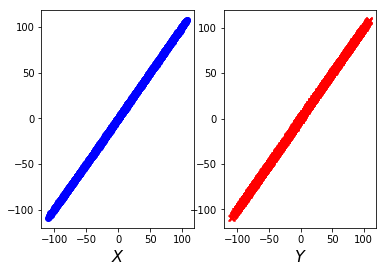

100%|██████████| 24/24 [00:00<00:00, 69.96it/s]

Epoch: 170 Train loss: 8.8035


Test loss: 8.6897


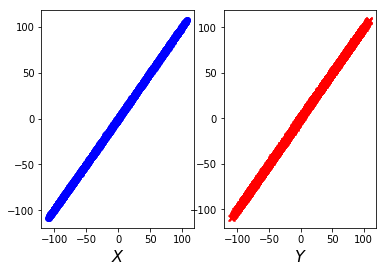

100%|██████████| 24/24 [00:00<00:00, 52.44it/s]

Epoch: 171 Train loss: 8.6206


Test loss: 8.3141


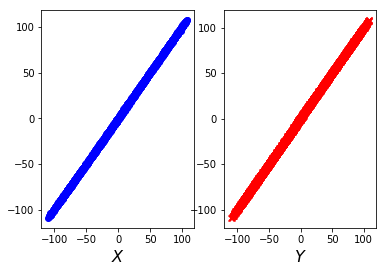

100%|██████████| 24/24 [00:00<00:00, 70.00it/s]

Epoch: 172 Train loss: 8.2853


Test loss: 8.2114


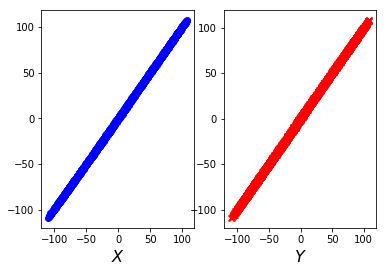

100%|██████████| 24/24 [00:00<00:00, 45.91it/s]

Epoch: 173 Train loss: 8.3942


Test loss: 8.1282


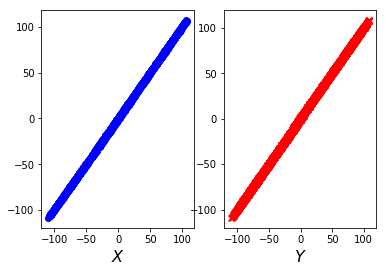

100%|██████████| 24/24 [00:00<00:00, 45.67it/s]

Epoch: 174 Train loss: 8.0574


Test loss: 7.9108


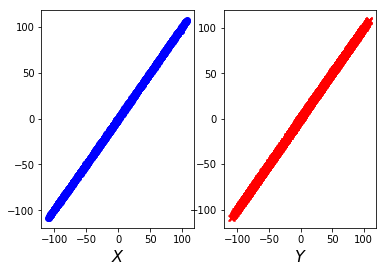

100%|██████████| 24/24 [00:00<00:00, 70.53it/s]

Epoch: 175 Train loss: 7.9901


Test loss: 7.7480


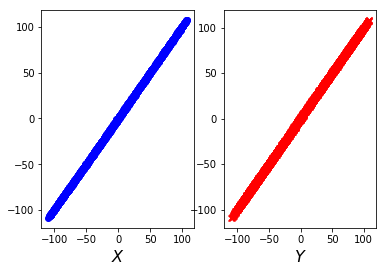

100%|██████████| 24/24 [00:00<00:00, 72.16it/s]

Epoch: 176 Train loss: 7.9316


Test loss: 7.5599


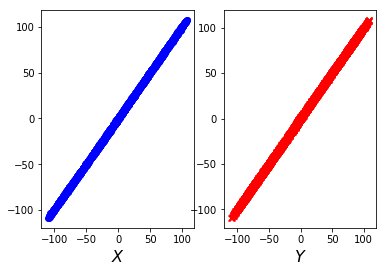

100%|██████████| 24/24 [00:00<00:00, 62.51it/s]

Epoch: 177 Train loss: 7.7081


Test loss: 7.5578


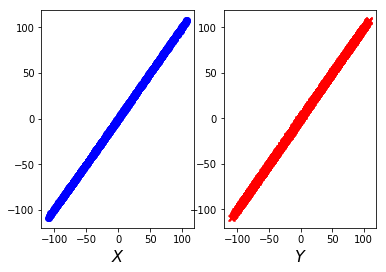

100%|██████████| 24/24 [00:00<00:00, 54.96it/s]

Epoch: 178 Train loss: 7.5046


Test loss: 7.3952


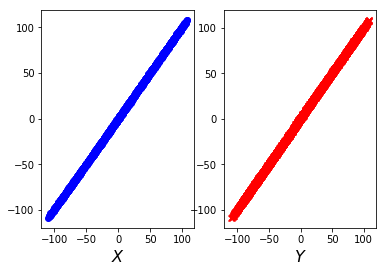

100%|██████████| 24/24 [00:00<00:00, 73.94it/s]

Epoch: 179 Train loss: 7.4178


Test loss: 7.3031


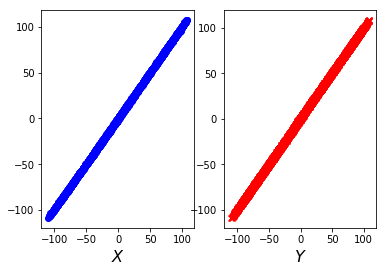

100%|██████████| 24/24 [00:00<00:00, 64.10it/s]

Epoch: 180 Train loss: 7.2214


Test loss: 7.1920


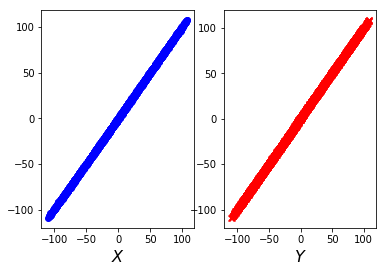

100%|██████████| 24/24 [00:00<00:00, 63.87it/s]

Epoch: 181 Train loss: 7.1083


Test loss: 6.9381


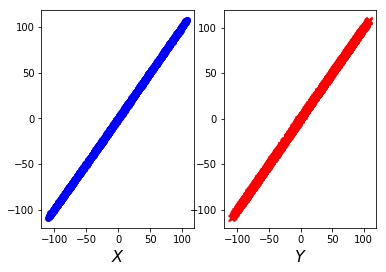

100%|██████████| 24/24 [00:00<00:00, 65.99it/s]

Epoch: 182 Train loss: 7.0177


Test loss: 6.8175


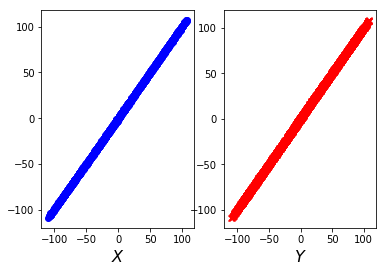

100%|██████████| 24/24 [00:00<00:00, 63.94it/s]

Epoch: 183 Train loss: 6.8242


Test loss: 6.6302


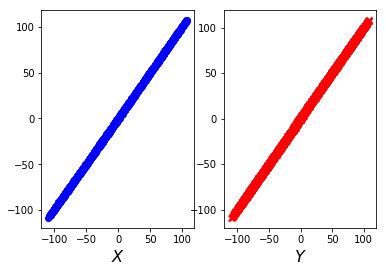

100%|██████████| 24/24 [00:00<00:00, 63.95it/s]

Epoch: 184 Train loss: 6.8957


Test loss: 6.7939


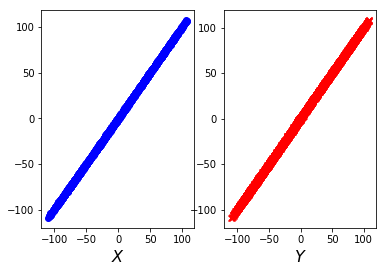

100%|██████████| 24/24 [00:00<00:00, 73.29it/s]

Epoch: 185 Train loss: 6.7642


Test loss: 6.6145


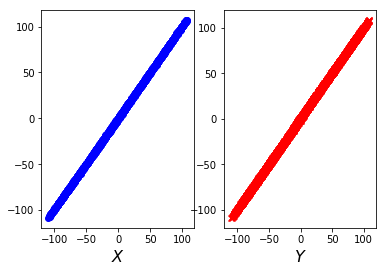

100%|██████████| 24/24 [00:00<00:00, 63.83it/s]

Epoch: 186 Train loss: 6.3968


Test loss: 6.5199


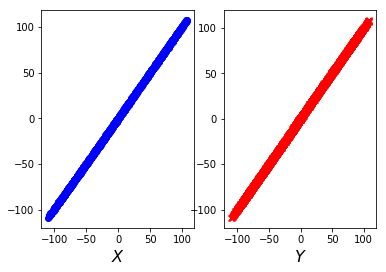

100%|██████████| 24/24 [00:00<00:00, 70.51it/s]

Epoch: 187 Train loss: 6.6220


Test loss: 6.3249


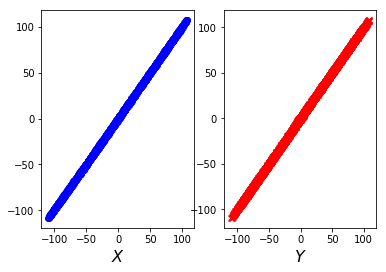

100%|██████████| 24/24 [00:00<00:00, 72.23it/s]

Epoch: 188 Train loss: 6.1667


Test loss: 6.3360


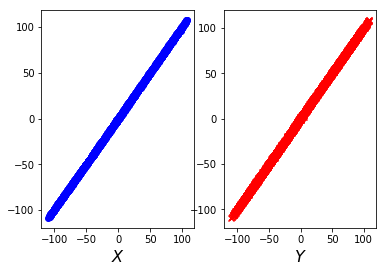

100%|██████████| 24/24 [00:00<00:00, 26.78it/s]

Epoch: 189 Train loss: 6.3610


Test loss: 6.2635


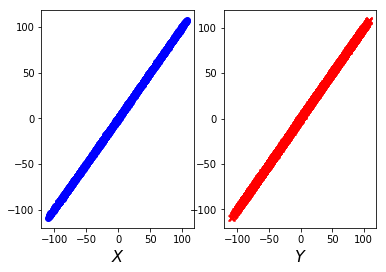

100%|██████████| 24/24 [00:00<00:00, 31.07it/s]

Epoch: 190 Train loss: 6.0977


Test loss: 6.0797


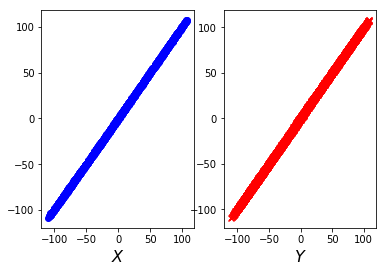

100%|██████████| 24/24 [00:00<00:00, 71.59it/s]

Epoch: 191 Train loss: 6.1033


Test loss: 6.0194


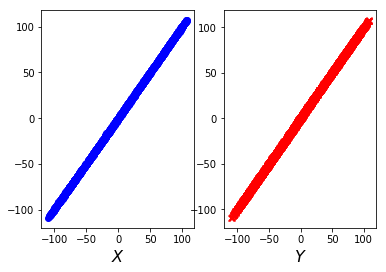

100%|██████████| 24/24 [00:00<00:00, 66.79it/s]

Epoch: 192 Train loss: 5.9302


Test loss: 6.0710


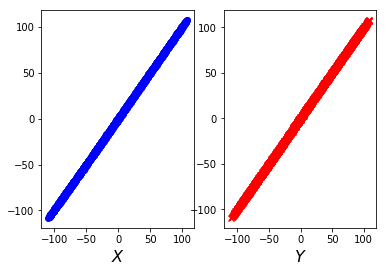

100%|██████████| 24/24 [00:00<00:00, 71.12it/s]

Epoch: 193 Train loss: 5.8926


Test loss: 5.7868


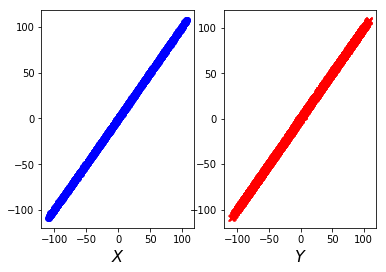

100%|██████████| 24/24 [00:00<00:00, 73.04it/s]

Epoch: 194 Train loss: 5.8709


Test loss: 5.7995


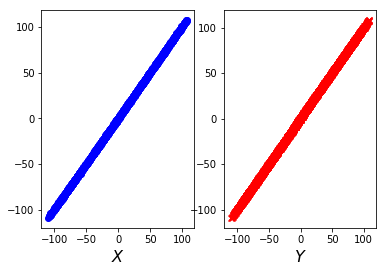

100%|██████████| 24/24 [00:00<00:00, 72.79it/s]

Epoch: 195 Train loss: 5.8997


Test loss: 5.7126


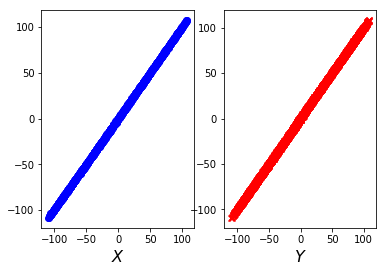

100%|██████████| 24/24 [00:00<00:00, 66.63it/s]

Epoch: 196 Train loss: 5.7079


Test loss: 5.6101


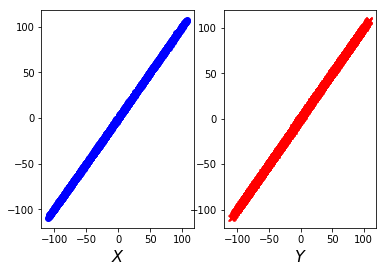

100%|██████████| 24/24 [00:00<00:00, 67.18it/s]

Epoch: 197 Train loss: 5.5167


Test loss: 5.5055


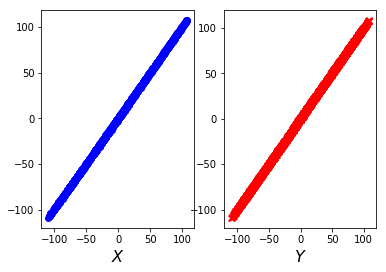

100%|██████████| 24/24 [00:00<00:00, 45.68it/s]

Epoch: 198 Train loss: 5.5648


Test loss: 5.6330


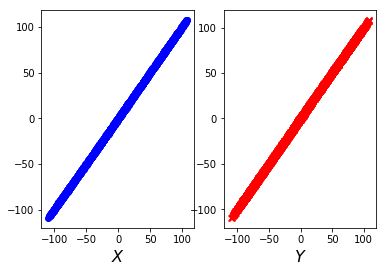

100%|██████████| 24/24 [00:00<00:00, 69.92it/s]

Epoch: 199 Train loss: 5.4181


Test loss: 5.4623


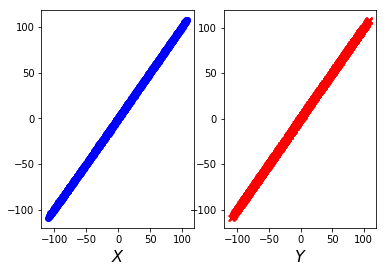

100%|██████████| 24/24 [00:00<00:00, 71.97it/s]

Epoch: 200 Train loss: 5.4113


Test loss: 5.4640


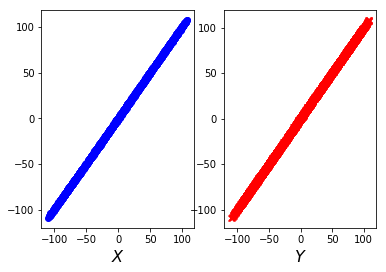

100%|██████████| 24/24 [00:00<00:00, 68.49it/s]

Epoch: 201 Train loss: 5.3489


Test loss: 5.2204


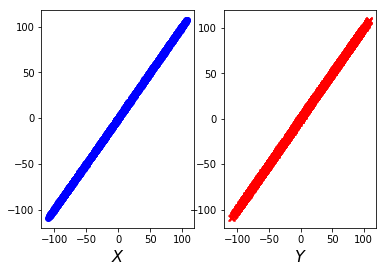

100%|██████████| 24/24 [00:00<00:00, 70.12it/s]

Epoch: 202 Train loss: 5.3245


Test loss: 5.2440


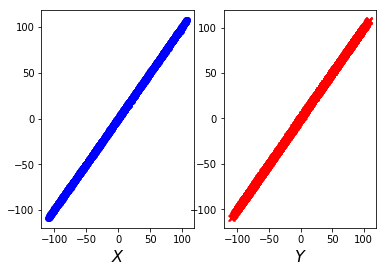

100%|██████████| 24/24 [00:00<00:00, 67.58it/s]

Epoch: 203 Train loss: 5.2525


Test loss: 5.1190


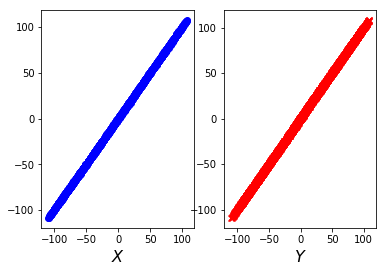

100%|██████████| 24/24 [00:00<00:00, 71.91it/s]

Epoch: 204 Train loss: 5.1896


Test loss: 5.0847


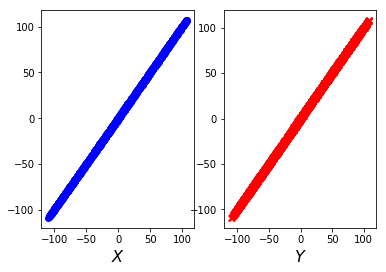

100%|██████████| 24/24 [00:00<00:00, 66.73it/s]

Epoch: 205 Train loss: 5.1691


Test loss: 5.0453


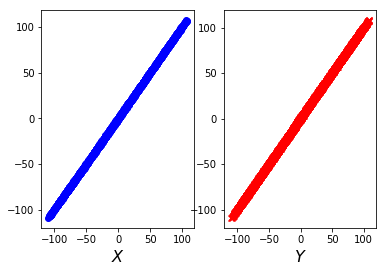

100%|██████████| 24/24 [00:00<00:00, 61.79it/s]

Epoch: 206 Train loss: 5.0685


Test loss: 5.0171


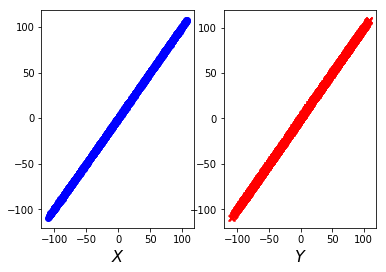

100%|██████████| 24/24 [00:00<00:00, 63.79it/s]

Epoch: 207 Train loss: 4.9192


Test loss: 4.9029


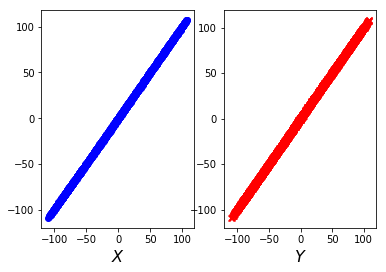

100%|██████████| 24/24 [00:00<00:00, 70.27it/s]

Epoch: 208 Train loss: 4.8927


Test loss: 4.8603


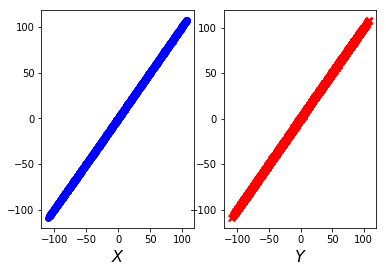

100%|██████████| 24/24 [00:00<00:00, 70.67it/s]

Epoch: 209 Train loss: 4.8922


Test loss: 4.7903


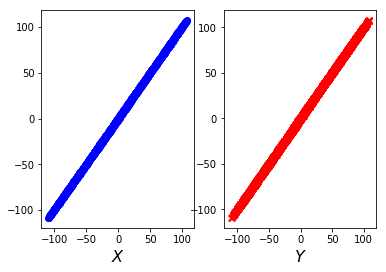

100%|██████████| 24/24 [00:00<00:00, 67.69it/s]

Epoch: 210 Train loss: 4.9471


Test loss: 4.7888


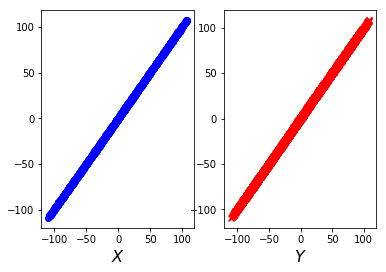

100%|██████████| 24/24 [00:00<00:00, 66.45it/s]

Epoch: 211 Train loss: 4.7571


Test loss: 4.7521


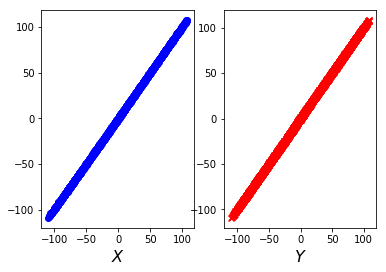

100%|██████████| 24/24 [00:00<00:00, 45.50it/s]

Epoch: 212 Train loss: 4.7199


Test loss: 4.7805


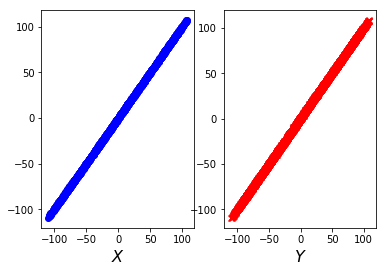

100%|██████████| 24/24 [00:00<00:00, 44.79it/s]

Epoch: 213 Train loss: 4.7381


Test loss: 4.6851


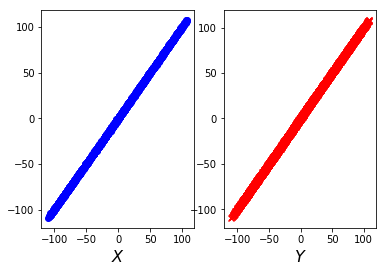

100%|██████████| 24/24 [00:00<00:00, 45.24it/s]

Epoch: 214 Train loss: 4.6006


Test loss: 4.5595


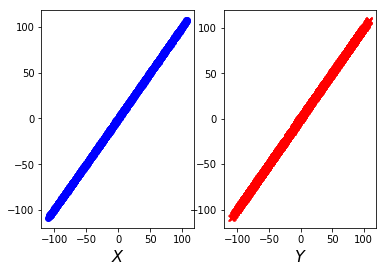

100%|██████████| 24/24 [00:00<00:00, 66.52it/s]

Epoch: 215 Train loss: 4.6348


Test loss: 4.6250


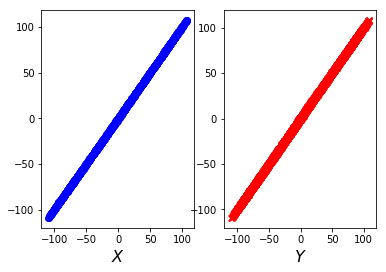

100%|██████████| 24/24 [00:00<00:00, 58.67it/s]

Epoch: 216 Train loss: 4.6058


Test loss: 4.5296


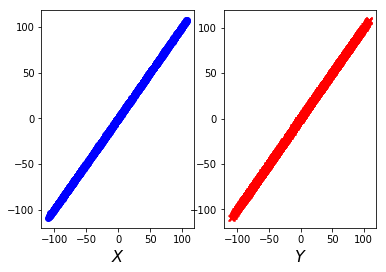

100%|██████████| 24/24 [00:00<00:00, 66.17it/s]

Epoch: 217 Train loss: 4.4927


Test loss: 4.5682


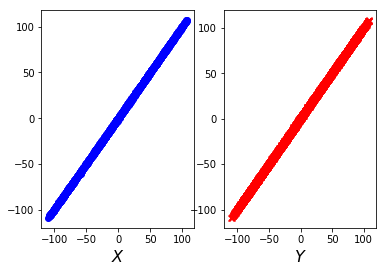

100%|██████████| 24/24 [00:00<00:00, 67.85it/s]

Epoch: 218 Train loss: 4.5127


Test loss: 4.4011


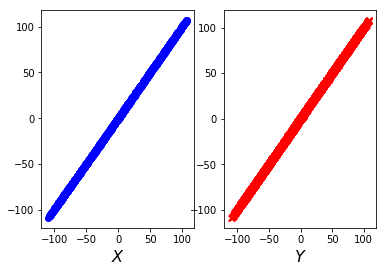

100%|██████████| 24/24 [00:00<00:00, 62.62it/s]

Epoch: 219 Train loss: 4.3951


Test loss: 4.2896


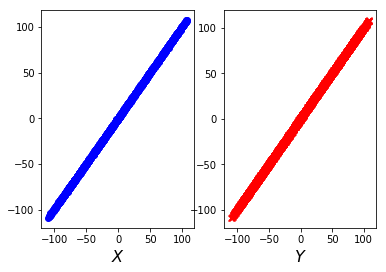

100%|██████████| 24/24 [00:00<00:00, 60.56it/s]

Epoch: 220 Train loss: 4.3834


Test loss: 4.4613


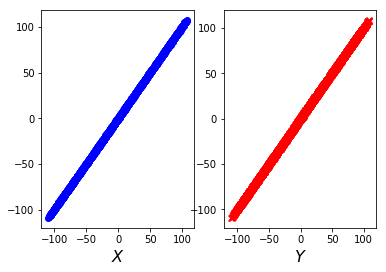

100%|██████████| 24/24 [00:00<00:00, 71.43it/s]

Epoch: 221 Train loss: 4.4027


Test loss: 4.1955


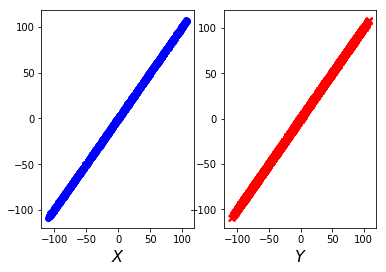

100%|██████████| 24/24 [00:00<00:00, 62.16it/s]

Epoch: 222 Train loss: 4.3642


Test loss: 4.3372


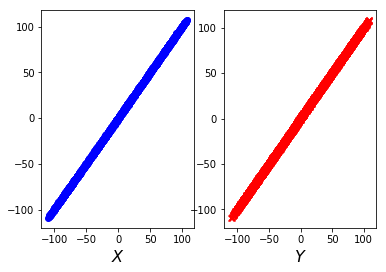

100%|██████████| 24/24 [00:00<00:00, 66.42it/s]

Epoch: 223 Train loss: 4.2737


Test loss: 4.1600


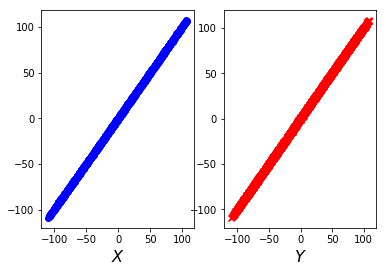

100%|██████████| 24/24 [00:00<00:00, 65.69it/s]

Epoch: 224 Train loss: 4.3317


Test loss: 4.2800


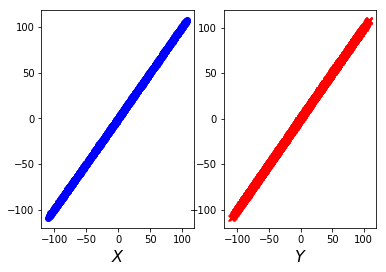

100%|██████████| 24/24 [00:00<00:00, 63.61it/s]

Epoch: 225 Train loss: 4.2867


Test loss: 4.2473


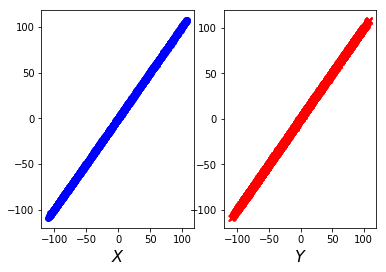

100%|██████████| 24/24 [00:00<00:00, 63.52it/s]

Epoch: 226 Train loss: 4.1479


Test loss: 4.1511


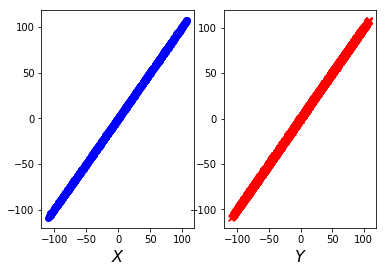

100%|██████████| 24/24 [00:00<00:00, 66.63it/s]

Epoch: 227 Train loss: 4.2365


Test loss: 4.1522


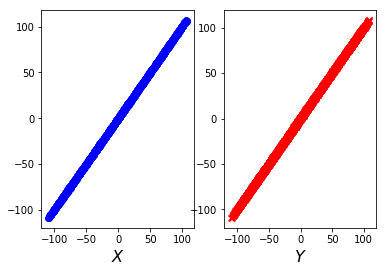

100%|██████████| 24/24 [00:00<00:00, 72.81it/s]

Epoch: 228 Train loss: 4.2432


Test loss: 3.9947


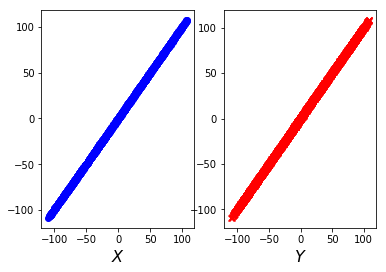

100%|██████████| 24/24 [00:00<00:00, 64.26it/s]

Epoch: 229 Train loss: 4.0680


Test loss: 4.1163


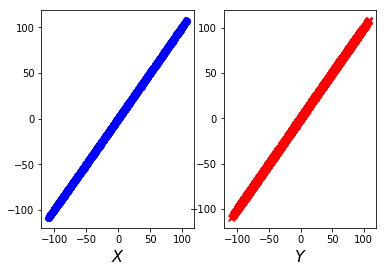

100%|██████████| 24/24 [00:00<00:00, 66.89it/s]

Epoch: 230 Train loss: 4.1602


Test loss: 4.0970


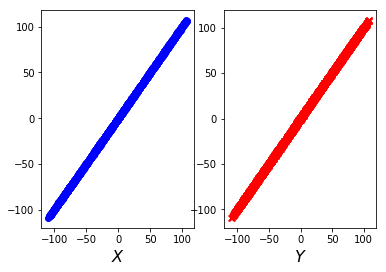

100%|██████████| 24/24 [00:00<00:00, 44.41it/s]

Epoch: 231 Train loss: 4.0892


Test loss: 4.0676


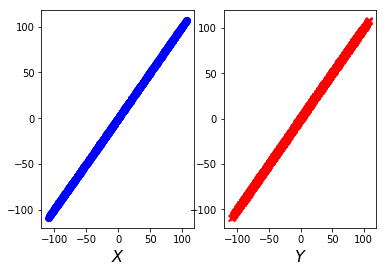

100%|██████████| 24/24 [00:00<00:00, 63.64it/s]

Epoch: 232 Train loss: 3.9854


Test loss: 3.9568


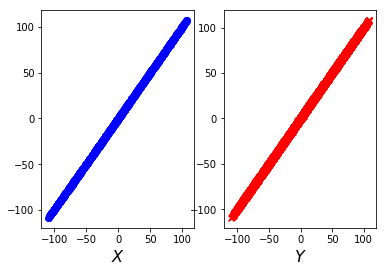

100%|██████████| 24/24 [00:00<00:00, 68.49it/s]

Epoch: 233 Train loss: 4.0764


Test loss: 3.8922


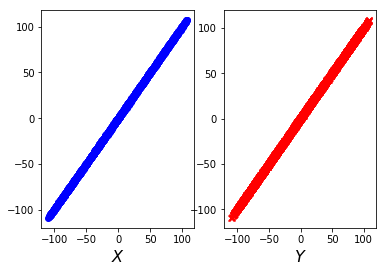

100%|██████████| 24/24 [00:00<00:00, 43.46it/s]

Epoch: 234 Train loss: 3.9330


Test loss: 3.9709


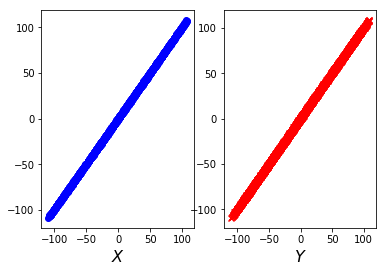

100%|██████████| 24/24 [00:00<00:00, 65.80it/s]

Epoch: 235 Train loss: 3.9717


Test loss: 3.9276


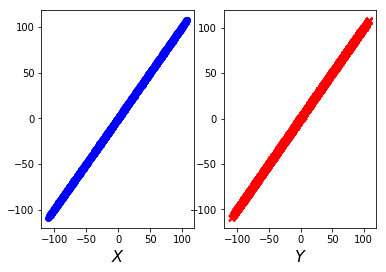

100%|██████████| 24/24 [00:00<00:00, 44.95it/s]

Epoch: 236 Train loss: 3.8984


Test loss: 3.8709


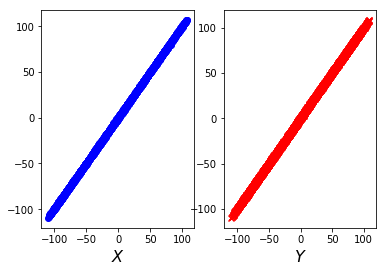

100%|██████████| 24/24 [00:00<00:00, 70.29it/s]

Epoch: 237 Train loss: 3.8897


Test loss: 3.8796


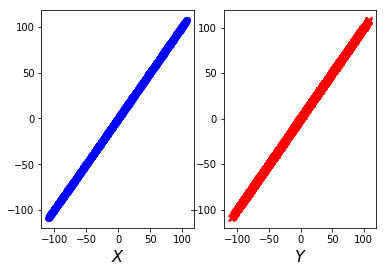

100%|██████████| 24/24 [00:00<00:00, 72.82it/s]

Epoch: 238 Train loss: 4.0509


Test loss: 4.1097


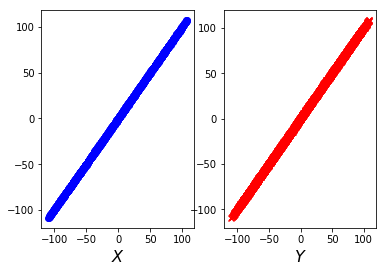

100%|██████████| 24/24 [00:00<00:00, 43.79it/s]

Epoch: 239 Train loss: 3.9713


Test loss: 3.9384


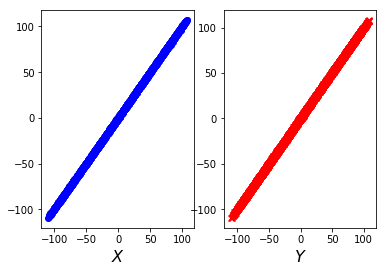

100%|██████████| 24/24 [00:00<00:00, 45.47it/s]

Epoch: 240 Train loss: 3.9629


Test loss: 3.9600


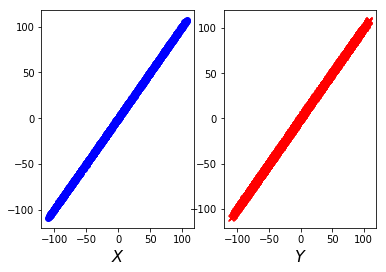

100%|██████████| 24/24 [00:00<00:00, 46.48it/s]

Epoch: 241 Train loss: 3.9341


Test loss: 3.8689


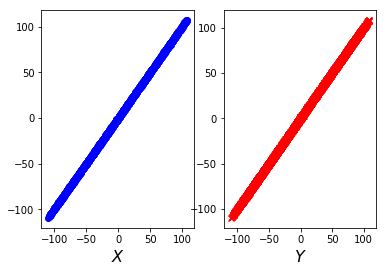

100%|██████████| 24/24 [00:00<00:00, 70.14it/s]

Epoch: 242 Train loss: 3.8751


Test loss: 3.8796


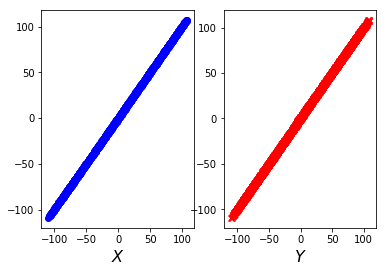

100%|██████████| 24/24 [00:00<00:00, 69.88it/s]

Epoch: 243 Train loss: 3.8059


Test loss: 3.7376


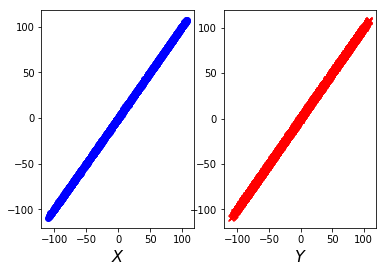

100%|██████████| 24/24 [00:00<00:00, 45.45it/s]

Epoch: 244 Train loss: 3.7661


Test loss: 3.7874


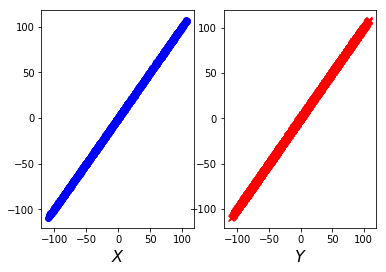

100%|██████████| 24/24 [00:00<00:00, 24.15it/s]

Epoch: 245 Train loss: 3.7982


Test loss: 3.7574


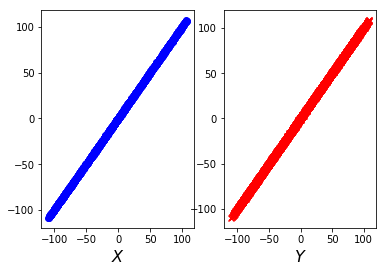

100%|██████████| 24/24 [00:00<00:00, 25.82it/s]

Epoch: 246 Train loss: 3.7531


Test loss: 3.8138


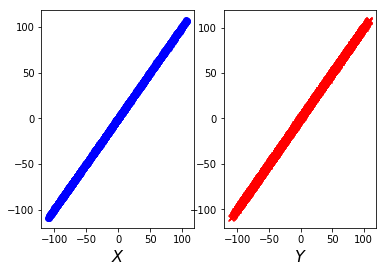

100%|██████████| 24/24 [00:00<00:00, 64.84it/s]

Epoch: 247 Train loss: 3.7586


Test loss: 3.7377


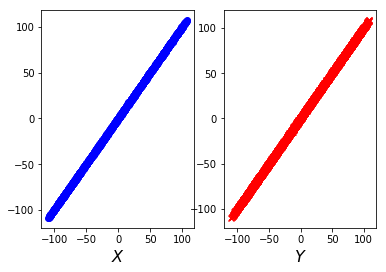

100%|██████████| 24/24 [00:00<00:00, 64.70it/s]

Epoch: 248 Train loss: 3.7503


Test loss: 3.8002


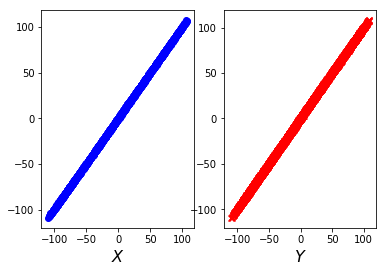

100%|██████████| 24/24 [00:00<00:00, 70.59it/s]

Epoch: 249 Train loss: 3.7033


Test loss: 3.8903


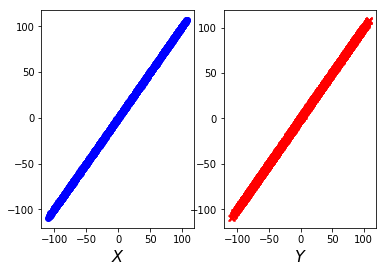

100%|██████████| 24/24 [00:00<00:00, 70.52it/s]

Epoch: 250 Train loss: 3.6854


Test loss: 3.7228


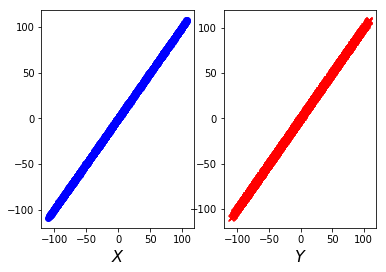

100%|██████████| 24/24 [00:00<00:00, 71.16it/s]

Epoch: 251 Train loss: 3.6919


Test loss: 3.5782


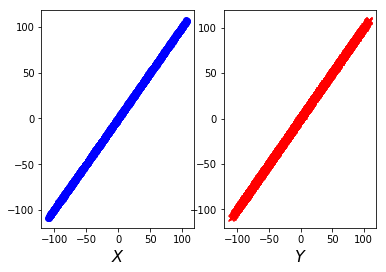

100%|██████████| 24/24 [00:00<00:00, 59.92it/s]

Epoch: 252 Train loss: 3.6608


Test loss: 3.6329


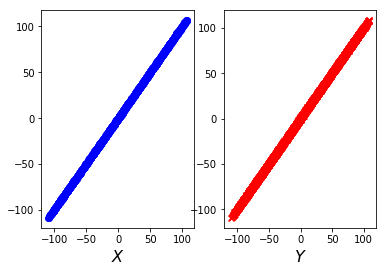

100%|██████████| 24/24 [00:00<00:00, 57.28it/s]

Epoch: 253 Train loss: 3.6399


Test loss: 3.6264


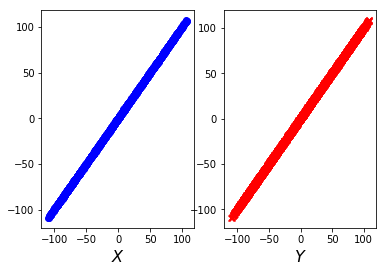

100%|██████████| 24/24 [00:00<00:00, 59.61it/s]

Epoch: 254 Train loss: 3.6530


Test loss: 3.6907


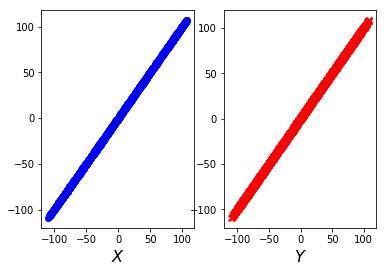

100%|██████████| 24/24 [00:00<00:00, 65.16it/s]

Epoch: 255 Train loss: 3.7078


Test loss: 3.6278


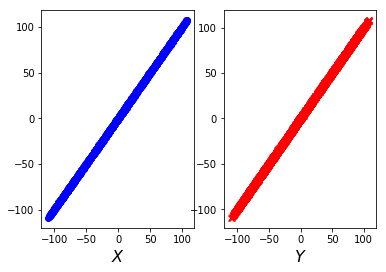

100%|██████████| 24/24 [00:00<00:00, 62.65it/s]

Epoch: 256 Train loss: 3.6299


Test loss: 3.5402


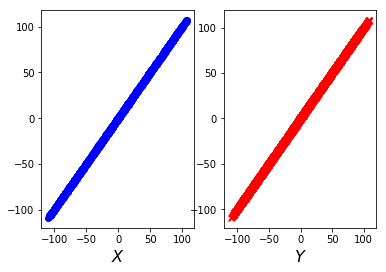

100%|██████████| 24/24 [00:00<00:00, 54.51it/s]

Epoch: 257 Train loss: 3.5815


Test loss: 3.5230


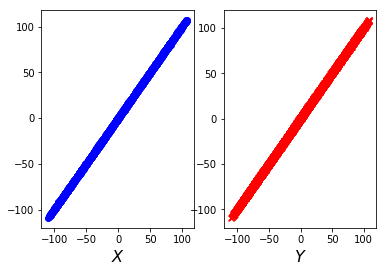

100%|██████████| 24/24 [00:00<00:00, 57.04it/s]

Epoch: 258 Train loss: 3.5967


Test loss: 3.5077


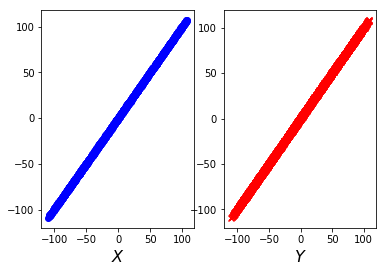

100%|██████████| 24/24 [00:00<00:00, 46.23it/s]

Epoch: 259 Train loss: 3.5308


Test loss: 3.5413


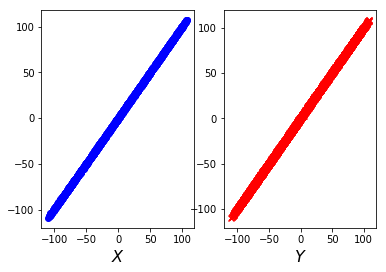

100%|██████████| 24/24 [00:00<00:00, 62.94it/s]

Epoch: 260 Train loss: 3.5246


Test loss: 3.4047


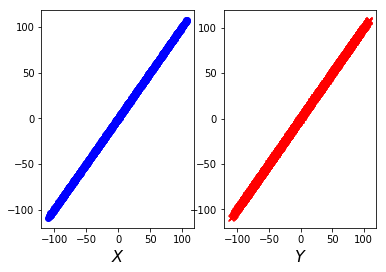

100%|██████████| 24/24 [00:00<00:00, 44.86it/s]

Epoch: 261 Train loss: 3.4209


Test loss: 3.5403


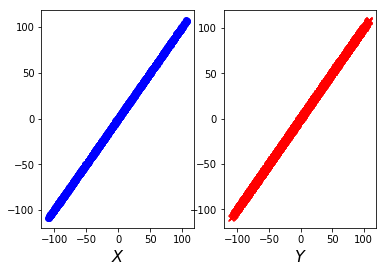

100%|██████████| 24/24 [00:00<00:00, 70.97it/s]

Epoch: 262 Train loss: 3.4283


Test loss: 3.3845


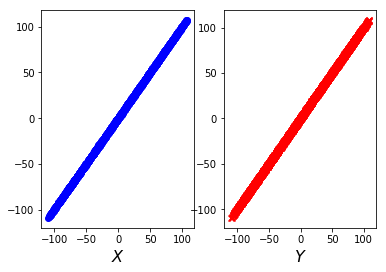

100%|██████████| 24/24 [00:00<00:00, 72.18it/s]

Epoch: 263 Train loss: 3.4117


Test loss: 3.4367


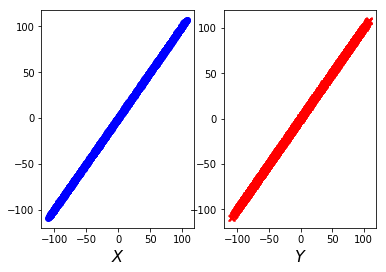

100%|██████████| 24/24 [00:00<00:00, 46.57it/s]

Epoch: 264 Train loss: 3.4781


Test loss: 3.3075


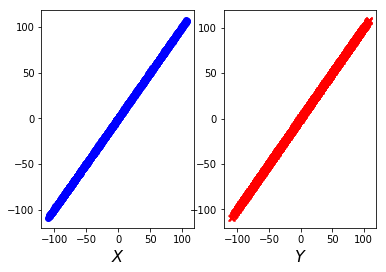

100%|██████████| 24/24 [00:00<00:00, 67.32it/s]

Epoch: 265 Train loss: 3.3909


Test loss: 3.4031


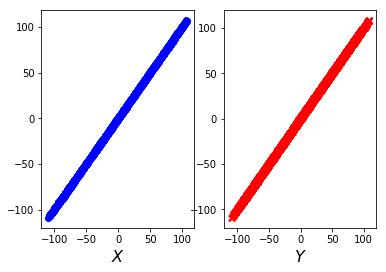

100%|██████████| 24/24 [00:00<00:00, 70.72it/s]

Epoch: 266 Train loss: 3.5038


Test loss: 3.3539


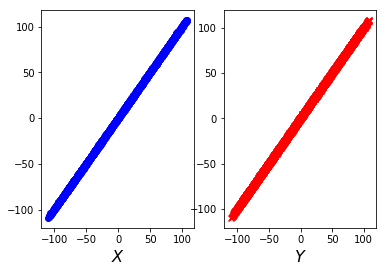

100%|██████████| 24/24 [00:00<00:00, 67.61it/s]

Epoch: 267 Train loss: 3.3867


Test loss: 3.3306


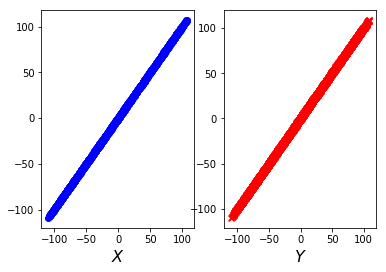

100%|██████████| 24/24 [00:00<00:00, 71.17it/s]

Epoch: 268 Train loss: 3.4588


Test loss: 3.4211


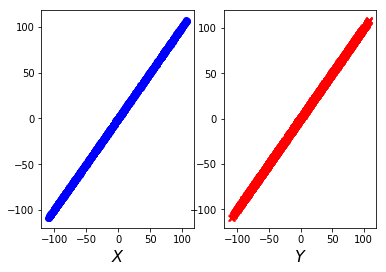

100%|██████████| 24/24 [00:00<00:00, 67.99it/s]

Epoch: 269 Train loss: 3.3935


Test loss: 3.4925


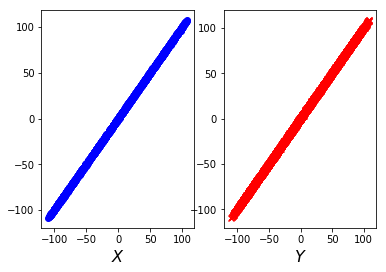

100%|██████████| 24/24 [00:00<00:00, 65.09it/s]

Epoch: 270 Train loss: 3.3837


Test loss: 3.3916


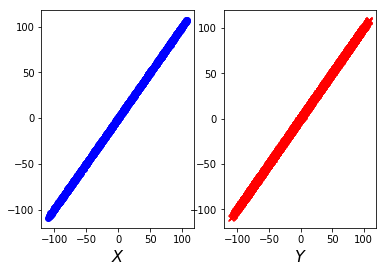

100%|██████████| 24/24 [00:00<00:00, 72.33it/s]

Epoch: 271 Train loss: 3.3573


Test loss: 3.3539


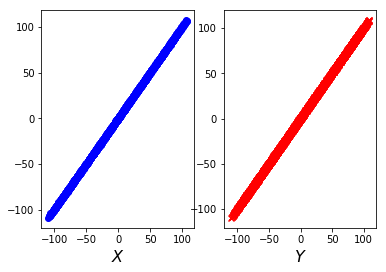

100%|██████████| 24/24 [00:00<00:00, 66.04it/s]

Epoch: 272 Train loss: 3.4181


Test loss: 3.3827


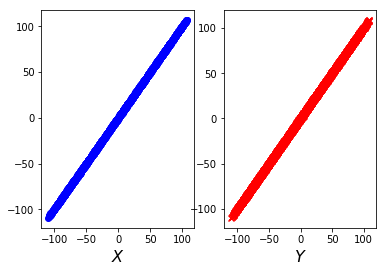

100%|██████████| 24/24 [00:00<00:00, 45.29it/s]

Epoch: 273 Train loss: 3.3416


Test loss: 3.2254


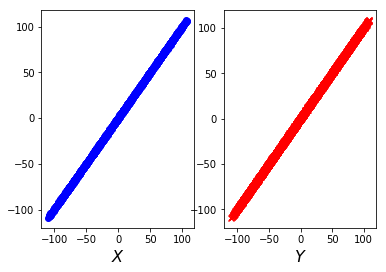

100%|██████████| 24/24 [00:00<00:00, 70.28it/s]

Epoch: 274 Train loss: 3.3249


Test loss: 3.2969


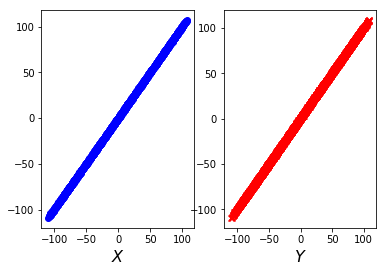

100%|██████████| 24/24 [00:00<00:00, 69.45it/s]

Epoch: 275 Train loss: 3.2934


Test loss: 3.2694


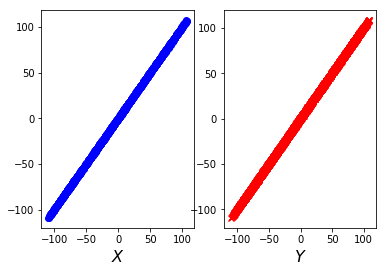

100%|██████████| 24/24 [00:00<00:00, 43.98it/s]

Epoch: 276 Train loss: 3.2571


Test loss: 3.2740


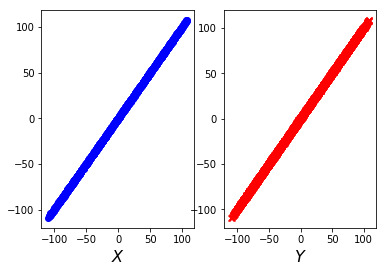

100%|██████████| 24/24 [00:00<00:00, 63.14it/s]

Epoch: 277 Train loss: 3.2822


Test loss: 3.2305


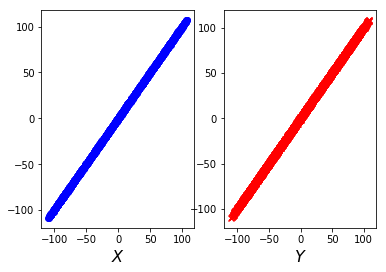

100%|██████████| 24/24 [00:00<00:00, 46.27it/s]

Epoch: 278 Train loss: 3.2919


Test loss: 3.3233


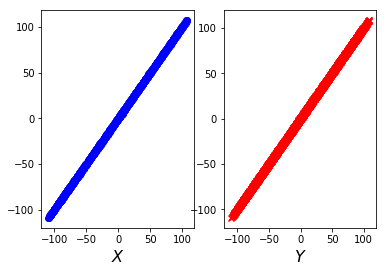

100%|██████████| 24/24 [00:00<00:00, 59.15it/s]

Epoch: 279 Train loss: 3.3455


Test loss: 3.3562


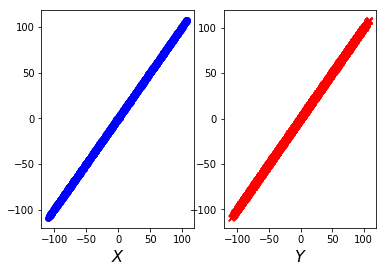

100%|██████████| 24/24 [00:00<00:00, 60.21it/s]

Epoch: 280 Train loss: 3.2970


Test loss: 3.2246


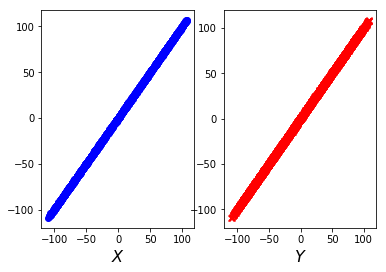

100%|██████████| 24/24 [00:00<00:00, 61.47it/s]

Epoch: 281 Train loss: 3.2873


Test loss: 3.3277


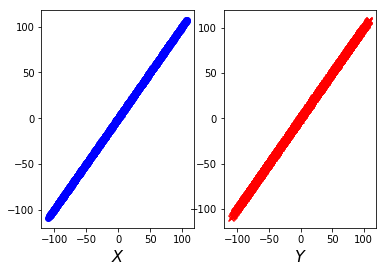

100%|██████████| 24/24 [00:00<00:00, 68.87it/s]

Epoch: 282 Train loss: 3.3760


Test loss: 3.2043


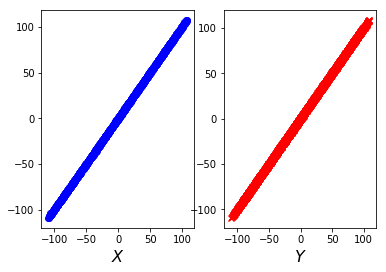

100%|██████████| 24/24 [00:00<00:00, 65.84it/s]

Epoch: 283 Train loss: 3.2769


Test loss: 3.2058


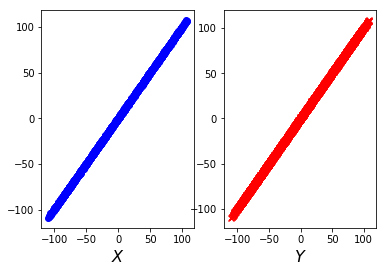

100%|██████████| 24/24 [00:00<00:00, 45.90it/s]

Epoch: 284 Train loss: 3.1728


Test loss: 3.1681


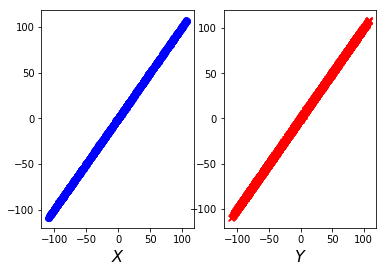

100%|██████████| 24/24 [00:00<00:00, 68.05it/s]

Epoch: 285 Train loss: 3.2016


Test loss: 3.2251


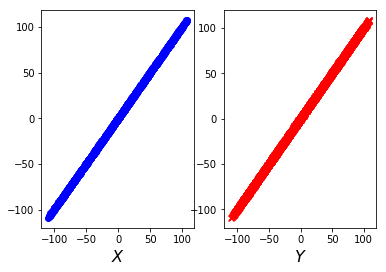

100%|██████████| 24/24 [00:00<00:00, 60.89it/s]

Epoch: 286 Train loss: 3.2910


Test loss: 3.1801


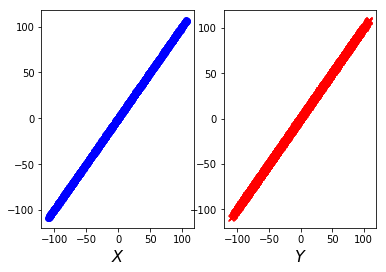

100%|██████████| 24/24 [00:00<00:00, 45.81it/s]

Epoch: 287 Train loss: 3.1960


Test loss: 3.2090


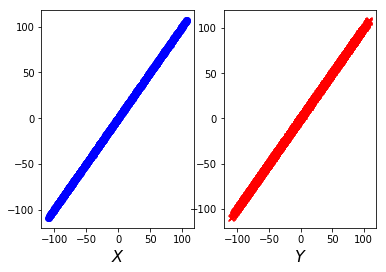

100%|██████████| 24/24 [00:00<00:00, 43.37it/s]

Epoch: 288 Train loss: 3.1467


Test loss: 3.1315


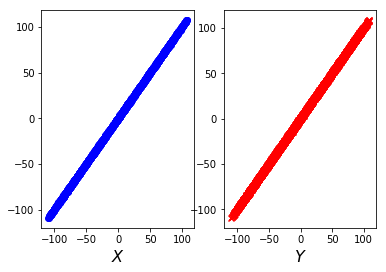

100%|██████████| 24/24 [00:00<00:00, 70.19it/s]

Epoch: 289 Train loss: 3.2192


Test loss: 3.2265


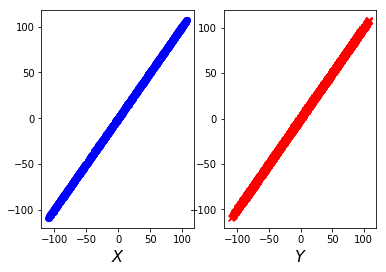

100%|██████████| 24/24 [00:00<00:00, 66.77it/s]

Epoch: 290 Train loss: 3.1673


Test loss: 3.1117


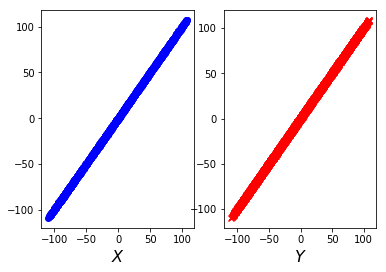

100%|██████████| 24/24 [00:00<00:00, 72.37it/s]

Epoch: 291 Train loss: 3.1915


Test loss: 3.3080


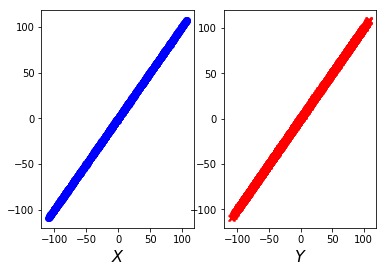

100%|██████████| 24/24 [00:00<00:00, 70.06it/s]

Epoch: 292 Train loss: 3.2340


Test loss: 3.1754


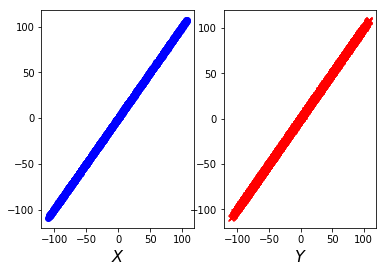

100%|██████████| 24/24 [00:00<00:00, 72.47it/s]

Epoch: 293 Train loss: 3.2595


Test loss: 3.2010


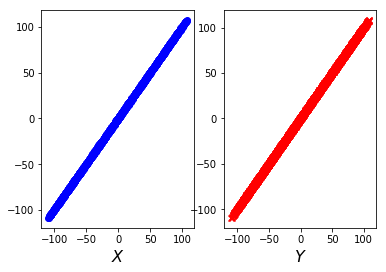

100%|██████████| 24/24 [00:00<00:00, 71.21it/s]

Epoch: 294 Train loss: 3.1825


Test loss: 3.1687


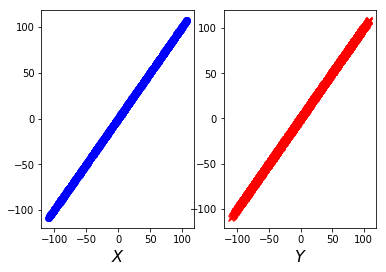

100%|██████████| 24/24 [00:00<00:00, 71.64it/s]

Epoch: 295 Train loss: 3.1819


Test loss: 3.0867


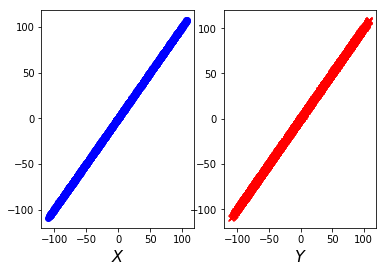

100%|██████████| 24/24 [00:00<00:00, 71.77it/s]

Epoch: 296 Train loss: 3.1744


Test loss: 3.1717


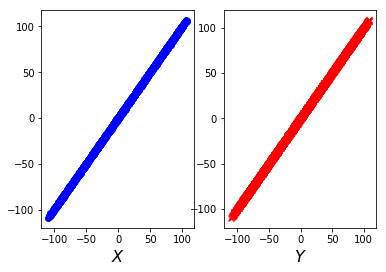

100%|██████████| 24/24 [00:00<00:00, 69.21it/s]

Epoch: 297 Train loss: 3.1706


Test loss: 3.1563


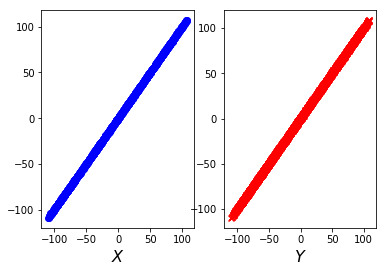

100%|██████████| 24/24 [00:00<00:00, 57.02it/s]

Epoch: 298 Train loss: 3.1840


Test loss: 3.1487


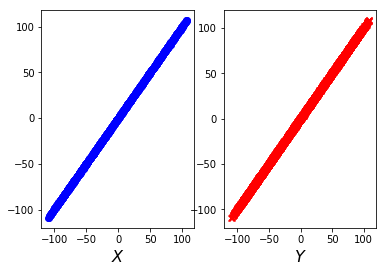

100%|██████████| 24/24 [00:00<00:00, 66.76it/s]

Epoch: 299 Train loss: 3.1738


Test loss: 3.2357


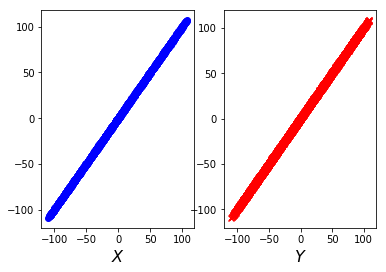

100%|██████████| 24/24 [00:00<00:00, 69.60it/s]

Epoch: 300 Train loss: 3.1726


Test loss: 3.1590


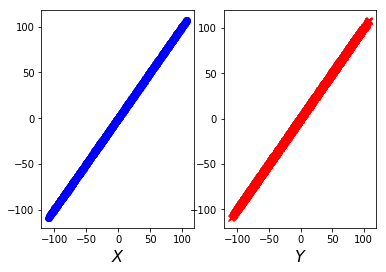

100%|██████████| 24/24 [00:00<00:00, 45.06it/s]

Epoch: 301 Train loss: 3.1387


Test loss: 3.1521


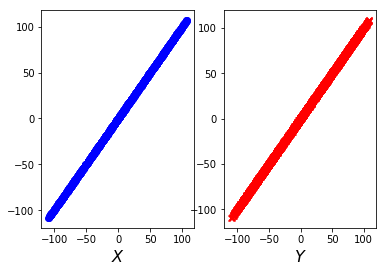

100%|██████████| 24/24 [00:00<00:00, 66.36it/s]

Epoch: 302 Train loss: 3.1640


Test loss: 3.1614


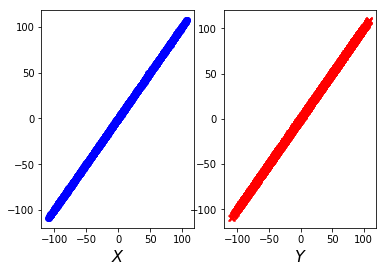

100%|██████████| 24/24 [00:00<00:00, 69.48it/s]

Epoch: 303 Train loss: 3.1219


Test loss: 3.0947


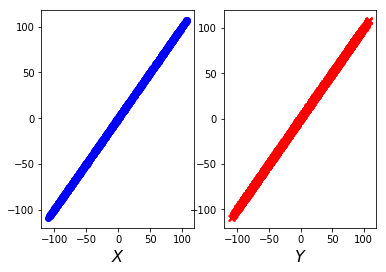

100%|██████████| 24/24 [00:00<00:00, 68.45it/s]

Epoch: 304 Train loss: 3.1198


Test loss: 3.2094


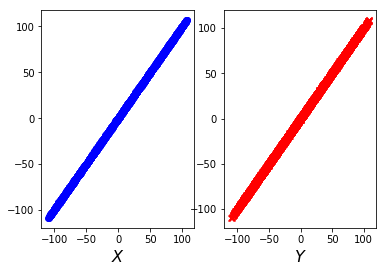

100%|██████████| 24/24 [00:00<00:00, 67.65it/s]

Epoch: 305 Train loss: 3.1913


Test loss: 3.1594


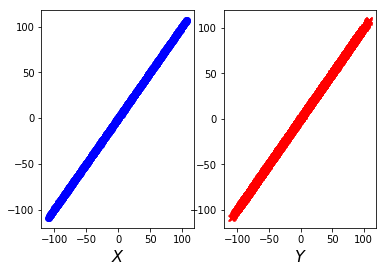

100%|██████████| 24/24 [00:00<00:00, 63.33it/s]

Epoch: 306 Train loss: 3.1205


Test loss: 3.0883


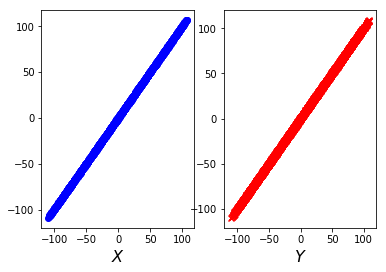

100%|██████████| 24/24 [00:00<00:00, 64.95it/s]

Epoch: 307 Train loss: 3.0249


Test loss: 3.1235


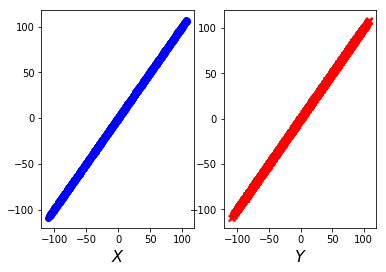

100%|██████████| 24/24 [00:00<00:00, 68.83it/s]

Epoch: 308 Train loss: 3.0826


Test loss: 3.0842


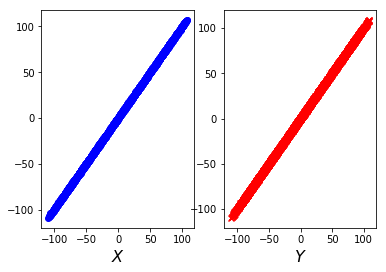

100%|██████████| 24/24 [00:00<00:00, 66.88it/s]

Epoch: 309 Train loss: 3.1429


Test loss: 3.0523


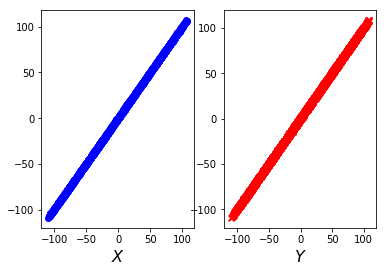

100%|██████████| 24/24 [00:00<00:00, 64.98it/s]

Epoch: 310 Train loss: 3.1740


Test loss: 3.0610


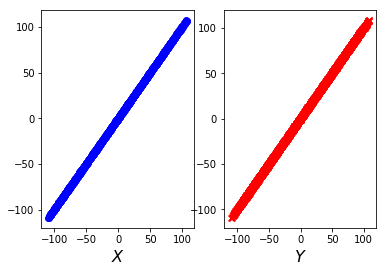

100%|██████████| 24/24 [00:00<00:00, 66.05it/s]

Epoch: 311 Train loss: 3.0752


Test loss: 3.1855


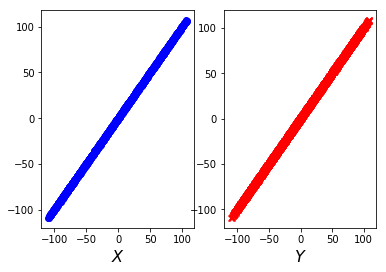

100%|██████████| 24/24 [00:00<00:00, 69.98it/s]

Epoch: 312 Train loss: 3.1578


Test loss: 3.0933


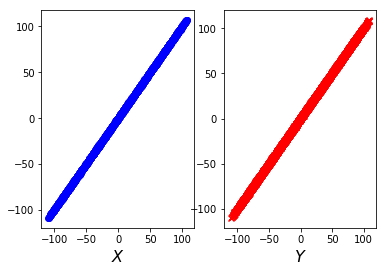

100%|██████████| 24/24 [00:00<00:00, 68.82it/s]

Epoch: 313 Train loss: 3.1396


Test loss: 3.1037


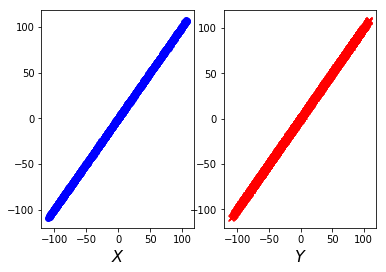

100%|██████████| 24/24 [00:01<00:00, 22.91it/s]

Epoch: 314 Train loss: 3.0567


Test loss: 3.1472


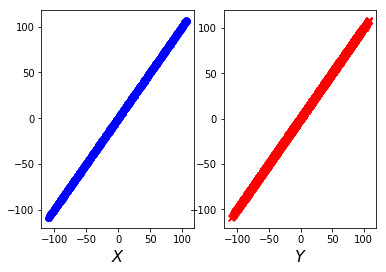

100%|██████████| 24/24 [00:01<00:00, 22.41it/s]

Epoch: 315 Train loss: 3.0290


Test loss: 3.0178


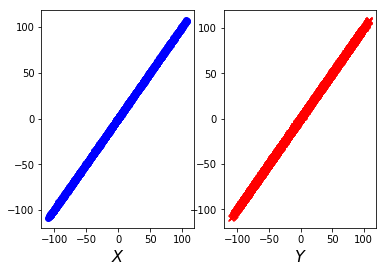

100%|██████████| 24/24 [00:00<00:00, 63.60it/s]

Epoch: 316 Train loss: 3.1349


Test loss: 3.0541


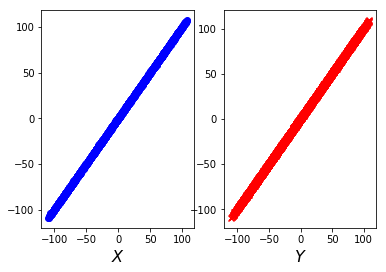

100%|██████████| 24/24 [00:00<00:00, 45.61it/s]

Epoch: 317 Train loss: 3.1028


Test loss: 3.0520


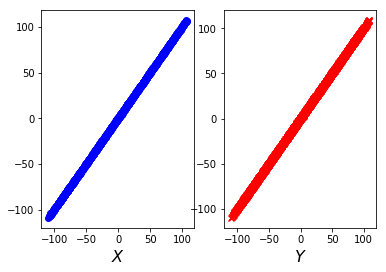

100%|██████████| 24/24 [00:00<00:00, 44.12it/s]

Epoch: 318 Train loss: 3.1117


Test loss: 3.0767


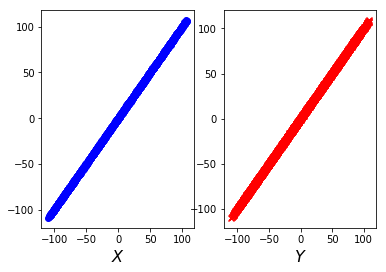

100%|██████████| 24/24 [00:00<00:00, 44.02it/s]

Epoch: 319 Train loss: 3.1142


Test loss: 3.0889


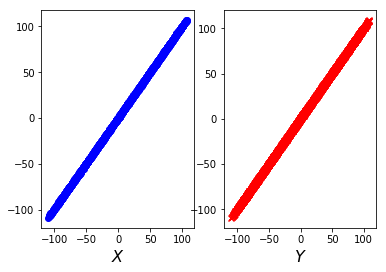

100%|██████████| 24/24 [00:00<00:00, 69.64it/s]

Epoch: 320 Train loss: 3.0494


Test loss: 3.0473


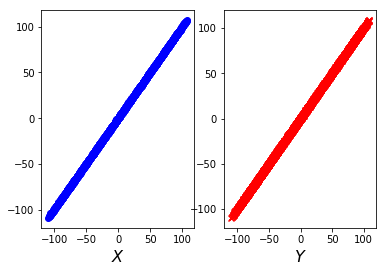

100%|██████████| 24/24 [00:00<00:00, 67.98it/s]

Epoch: 321 Train loss: 3.0034


Test loss: 3.1866


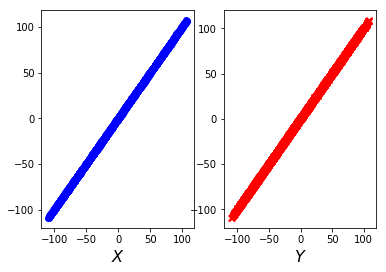

100%|██████████| 24/24 [00:00<00:00, 60.73it/s]


Epoch: 322 Train loss: 3.0929
Test loss: 3.0714


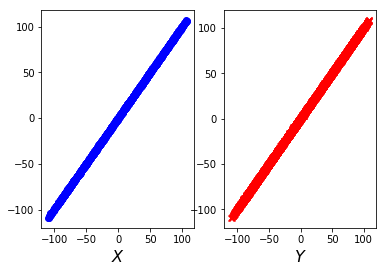

100%|██████████| 24/24 [00:00<00:00, 60.35it/s]

Epoch: 323 Train loss: 3.0747


Test loss: 3.0946


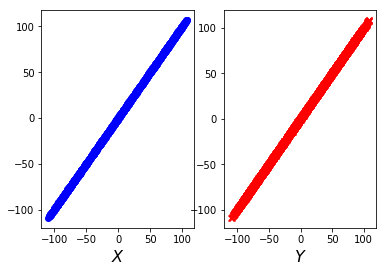

100%|██████████| 24/24 [00:00<00:00, 44.38it/s]

Epoch: 324 Train loss: 3.1121


Test loss: 3.1390


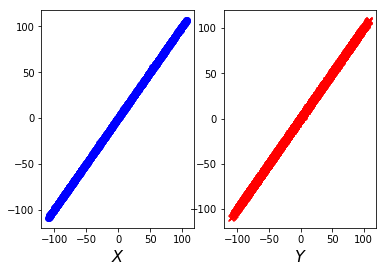

100%|██████████| 24/24 [00:00<00:00, 46.45it/s]

Epoch: 325 Train loss: 3.1365


Test loss: 3.1646


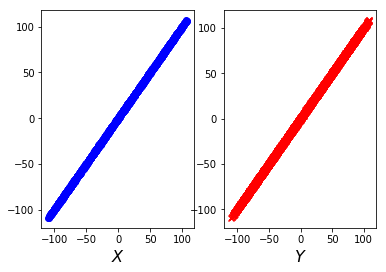

100%|██████████| 24/24 [00:00<00:00, 66.88it/s]

Epoch: 326 Train loss: 3.0233


Test loss: 3.1360


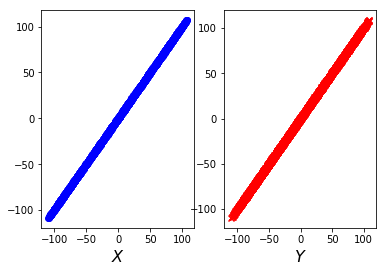

100%|██████████| 24/24 [00:00<00:00, 62.41it/s]

Epoch: 327 Train loss: 3.0715


Test loss: 3.1054


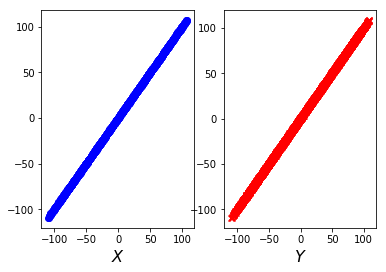

100%|██████████| 24/24 [00:00<00:00, 69.60it/s]

Epoch: 328 Train loss: 3.0174


Test loss: 3.0106


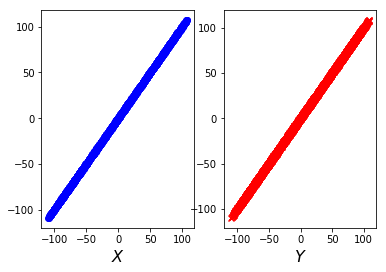

100%|██████████| 24/24 [00:00<00:00, 45.88it/s]

Epoch: 329 Train loss: 3.0896


Test loss: 3.1709


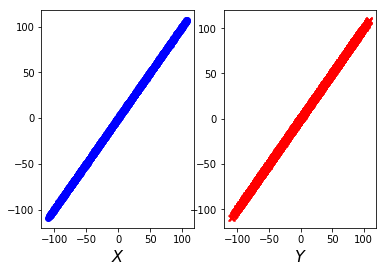

100%|██████████| 24/24 [00:00<00:00, 67.16it/s]

Epoch: 330 Train loss: 3.1017


Test loss: 3.1344


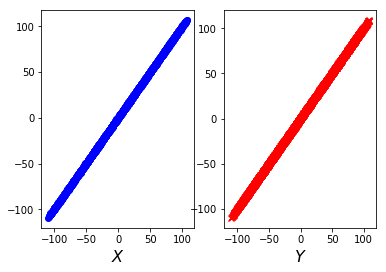

100%|██████████| 24/24 [00:00<00:00, 64.30it/s]

Epoch: 331 Train loss: 3.0171


Test loss: 3.2196


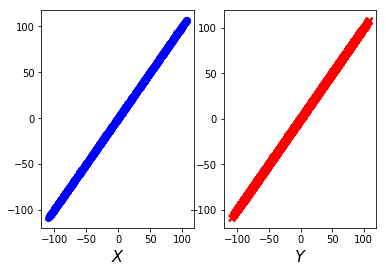

100%|██████████| 24/24 [00:00<00:00, 67.47it/s]

Epoch: 332 Train loss: 3.0752


Test loss: 3.0457


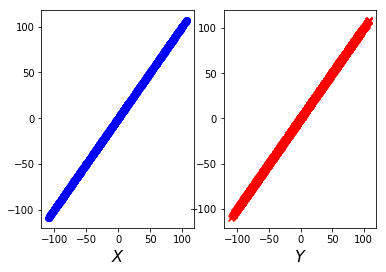

100%|██████████| 24/24 [00:00<00:00, 66.60it/s]

Epoch: 333 Train loss: 3.1255


Test loss: 3.2462


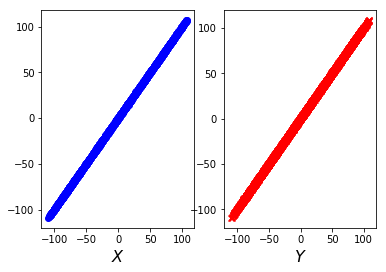

100%|██████████| 24/24 [00:00<00:00, 69.10it/s]

Epoch: 334 Train loss: 3.2315


Test loss: 3.1559


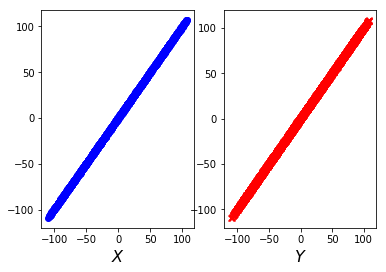

100%|██████████| 24/24 [00:00<00:00, 62.77it/s]

Epoch: 335 Train loss: 3.1771


Test loss: 3.0285


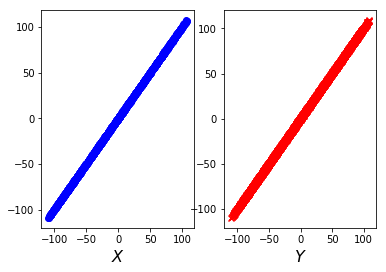

100%|██████████| 24/24 [00:00<00:00, 66.71it/s]

Epoch: 336 Train loss: 3.0710


Test loss: 3.0440


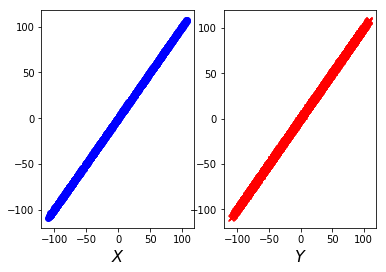

100%|██████████| 24/24 [00:00<00:00, 43.94it/s]

Epoch: 337 Train loss: 3.0514


Test loss: 3.1085


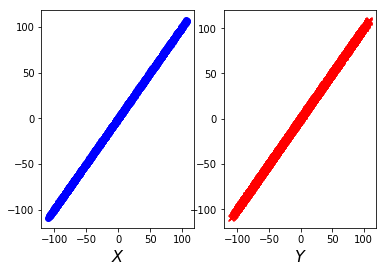

100%|██████████| 24/24 [00:00<00:00, 54.57it/s]

Epoch: 338 Train loss: 3.0970


Test loss: 3.0800


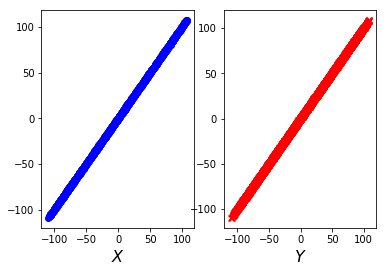

100%|██████████| 24/24 [00:00<00:00, 63.72it/s]

Epoch: 339 Train loss: 3.1020


Test loss: 2.9222


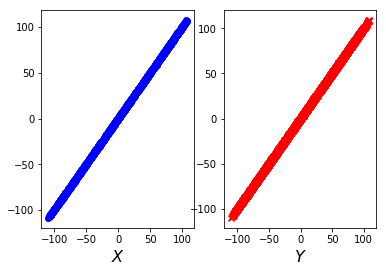

100%|██████████| 24/24 [00:00<00:00, 68.28it/s]

Epoch: 340 Train loss: 3.0833


Test loss: 3.0209


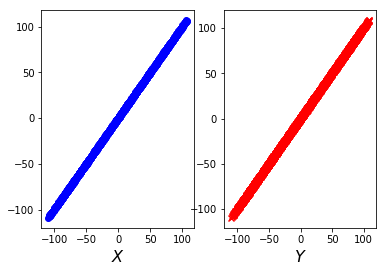

100%|██████████| 24/24 [00:00<00:00, 62.81it/s]

Epoch: 341 Train loss: 2.9983


Test loss: 3.1948


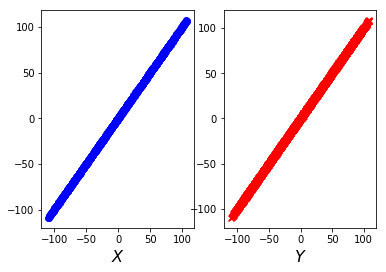

100%|██████████| 24/24 [00:00<00:00, 70.20it/s]

Epoch: 342 Train loss: 3.0552


Test loss: 3.0998


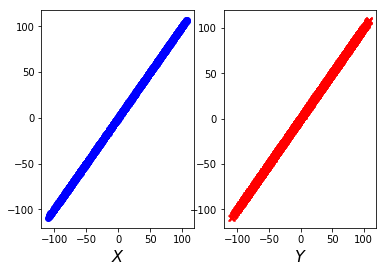

100%|██████████| 24/24 [00:00<00:00, 71.84it/s]

Epoch: 343 Train loss: 3.0884


Test loss: 3.0602


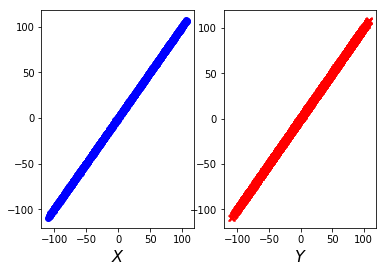

100%|██████████| 24/24 [00:00<00:00, 43.58it/s]

Epoch: 344 Train loss: 3.0911


Test loss: 3.0431


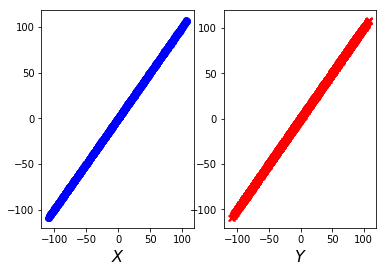

100%|██████████| 24/24 [00:00<00:00, 66.80it/s]

Epoch: 345 Train loss: 3.0533


Test loss: 3.0766


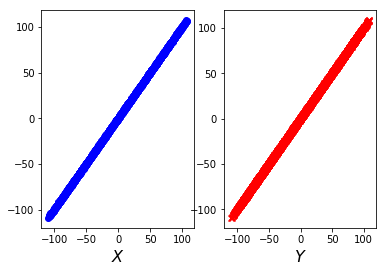

100%|██████████| 24/24 [00:00<00:00, 46.50it/s]

Epoch: 346 Train loss: 3.1073


Test loss: 3.0511


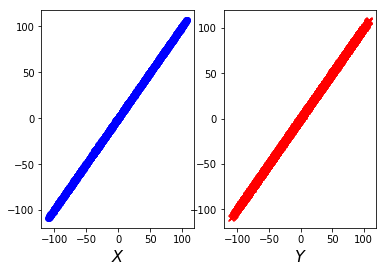

100%|██████████| 24/24 [00:00<00:00, 72.08it/s]

Epoch: 347 Train loss: 2.9855


Test loss: 3.0149


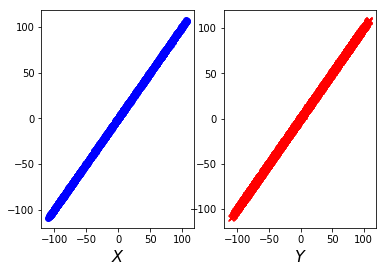

100%|██████████| 24/24 [00:00<00:00, 45.23it/s]

Epoch: 348 Train loss: 3.0066


Test loss: 3.2281


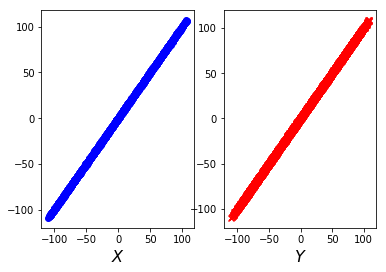

100%|██████████| 24/24 [00:00<00:00, 62.40it/s]

Epoch: 349 Train loss: 3.0685


Test loss: 2.9630


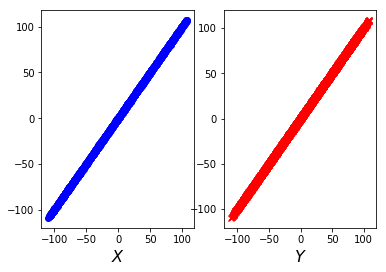

100%|██████████| 24/24 [00:00<00:00, 45.40it/s]

Epoch: 350 Train loss: 3.0057


Test loss: 3.0969


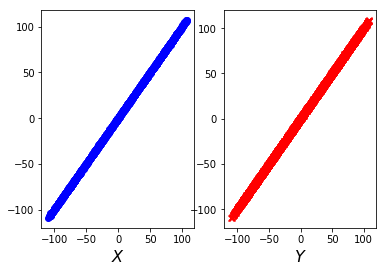

100%|██████████| 24/24 [00:00<00:00, 46.48it/s]

Epoch: 351 Train loss: 3.1118


Test loss: 3.1645


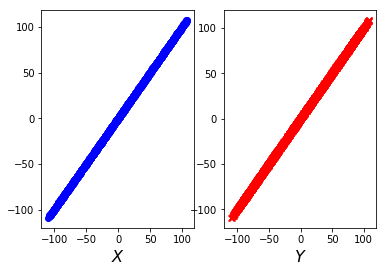

100%|██████████| 24/24 [00:00<00:00, 44.33it/s]

Epoch: 352 Train loss: 3.0342


Test loss: 3.2506


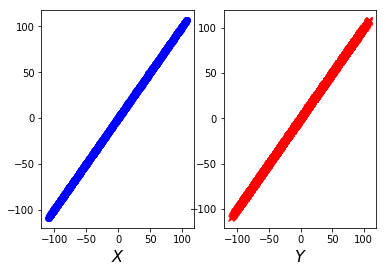

100%|██████████| 24/24 [00:00<00:00, 68.74it/s]

Epoch: 353 Train loss: 2.9897


Test loss: 3.0034


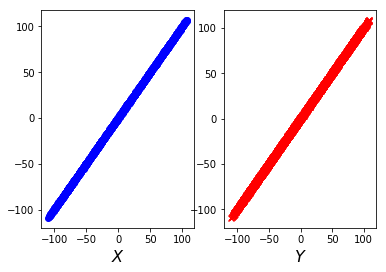

100%|██████████| 24/24 [00:00<00:00, 45.78it/s]

Epoch: 354 Train loss: 3.0832


Test loss: 2.9579


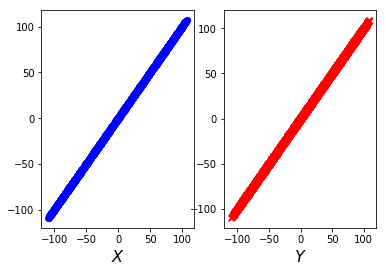

100%|██████████| 24/24 [00:00<00:00, 56.94it/s]

Epoch: 355 Train loss: 3.0352


Test loss: 3.1774


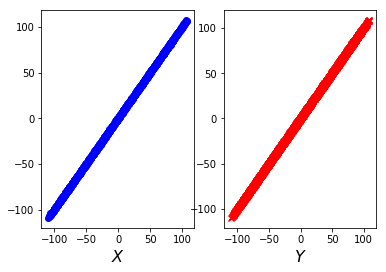

100%|██████████| 24/24 [00:00<00:00, 63.80it/s]

Epoch: 356 Train loss: 2.9841


Test loss: 3.1201


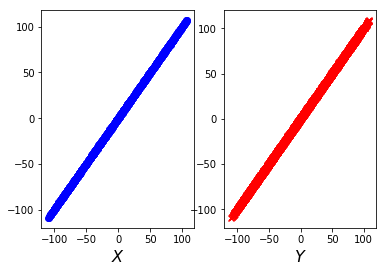

100%|██████████| 24/24 [00:00<00:00, 66.11it/s]

Epoch: 357 Train loss: 2.9752


Test loss: 2.9791


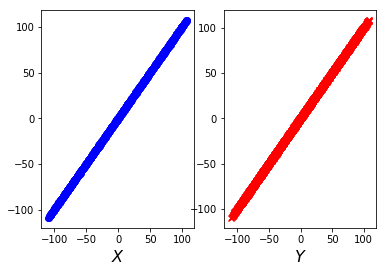

100%|██████████| 24/24 [00:00<00:00, 64.94it/s]

Epoch: 358 Train loss: 3.0344


Test loss: 3.2227


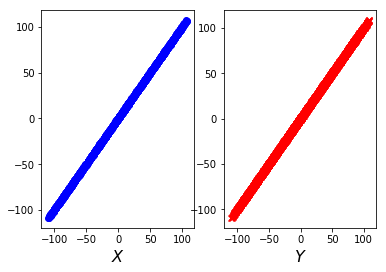

100%|██████████| 24/24 [00:00<00:00, 45.20it/s]

Epoch: 359 Train loss: 3.0055


Test loss: 3.1116


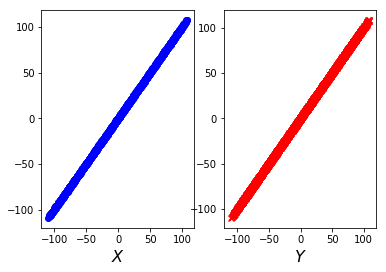

100%|██████████| 24/24 [00:00<00:00, 44.95it/s]

Epoch: 360 Train loss: 3.0980


Test loss: 3.0197


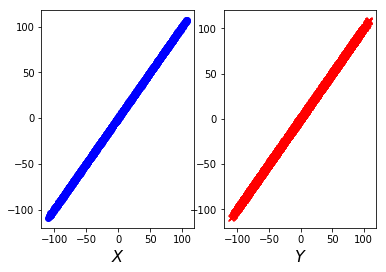

100%|██████████| 24/24 [00:00<00:00, 61.04it/s]

Epoch: 361 Train loss: 2.9699


Test loss: 3.0332


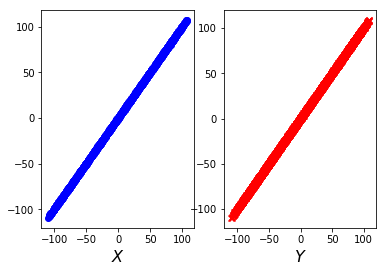

100%|██████████| 24/24 [00:00<00:00, 63.76it/s]

Epoch: 362 Train loss: 2.9906


Test loss: 3.0119


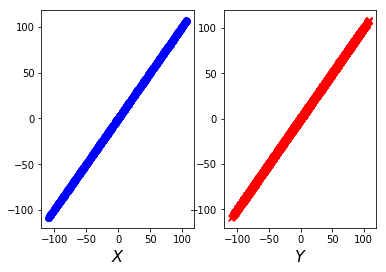

100%|██████████| 24/24 [00:00<00:00, 44.73it/s]

Epoch: 363 Train loss: 3.0329


Test loss: 2.9728


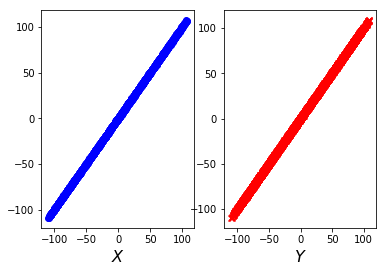

100%|██████████| 24/24 [00:00<00:00, 69.64it/s]

Epoch: 364 Train loss: 2.9662


Test loss: 3.1236


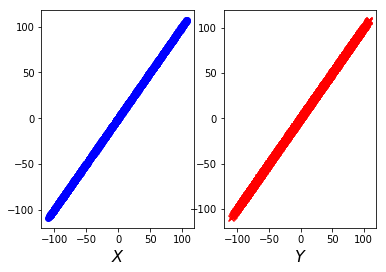

100%|██████████| 24/24 [00:00<00:00, 66.27it/s]

Epoch: 365 Train loss: 2.9181


Test loss: 2.9145


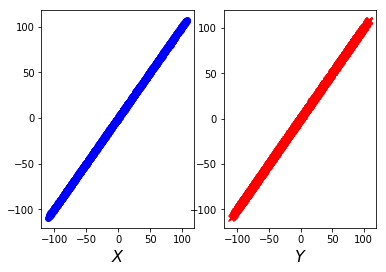

100%|██████████| 24/24 [00:00<00:00, 44.78it/s]

Epoch: 366 Train loss: 3.0230


Test loss: 2.9250


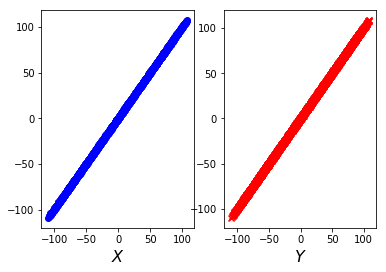

100%|██████████| 24/24 [00:00<00:00, 68.74it/s]

Epoch: 367 Train loss: 3.0191


Test loss: 3.0106


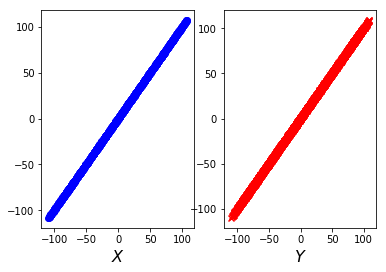

100%|██████████| 24/24 [00:00<00:00, 45.63it/s]

Epoch: 368 Train loss: 3.0036


Test loss: 2.9600


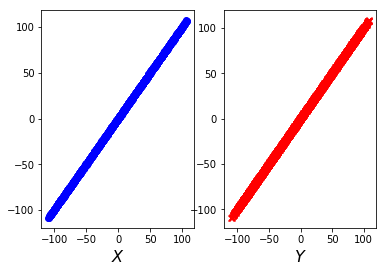

100%|██████████| 24/24 [00:00<00:00, 44.75it/s]

Epoch: 369 Train loss: 2.9850


Test loss: 3.1077


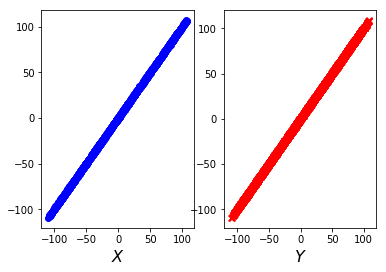

100%|██████████| 24/24 [00:00<00:00, 53.40it/s]

Epoch: 370 Train loss: 2.9997


Test loss: 2.9861


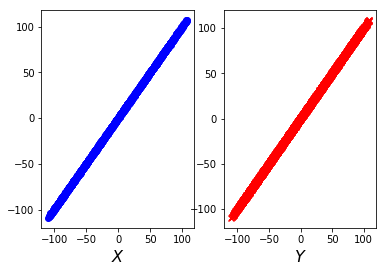

100%|██████████| 24/24 [00:00<00:00, 67.77it/s]

Epoch: 371 Train loss: 3.0577


Test loss: 3.5037


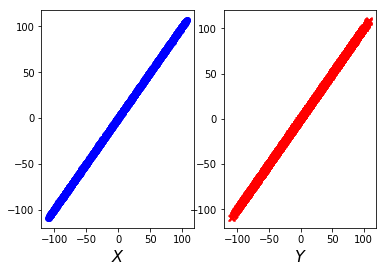

100%|██████████| 24/24 [00:00<00:00, 61.72it/s]

Epoch: 372 Train loss: 3.1787


Test loss: 2.9918


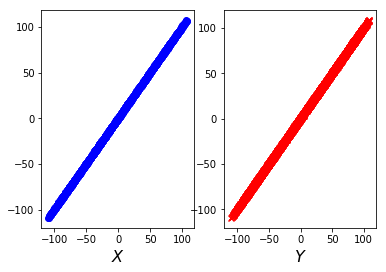

100%|██████████| 24/24 [00:00<00:00, 60.80it/s]

Epoch: 373 Train loss: 3.0302


Test loss: 2.9616


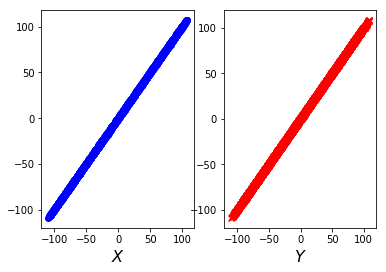

100%|██████████| 24/24 [00:00<00:00, 44.71it/s]

Epoch: 374 Train loss: 2.9969


Test loss: 2.9110


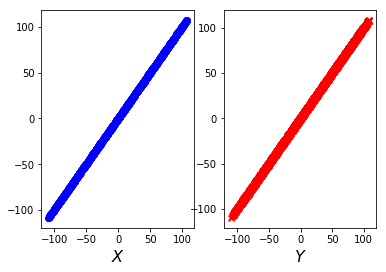

100%|██████████| 24/24 [00:00<00:00, 59.59it/s]

Epoch: 375 Train loss: 2.9291


Test loss: 3.0451


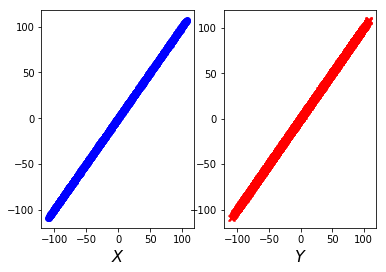

100%|██████████| 24/24 [00:00<00:00, 69.95it/s]

Epoch: 376 Train loss: 2.9738


Test loss: 3.0215


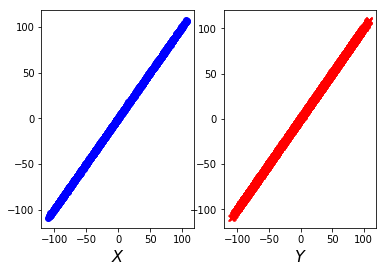

100%|██████████| 24/24 [00:00<00:00, 45.18it/s]

Epoch: 377 Train loss: 3.0274


Test loss: 3.0436


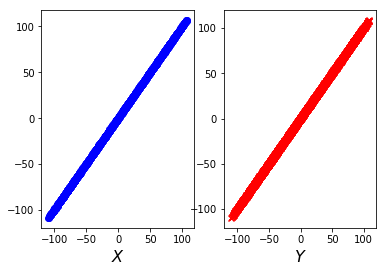

100%|██████████| 24/24 [00:00<00:00, 60.41it/s]

Epoch: 378 Train loss: 3.1270


Test loss: 3.0279


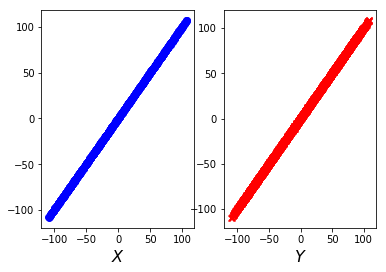

100%|██████████| 24/24 [00:00<00:00, 43.90it/s]

Epoch: 379 Train loss: 3.0684


Test loss: 3.0196


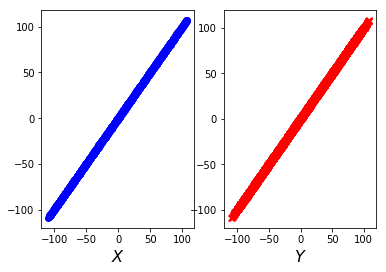

100%|██████████| 24/24 [00:00<00:00, 65.03it/s]

Epoch: 380 Train loss: 2.9778


Test loss: 3.0316


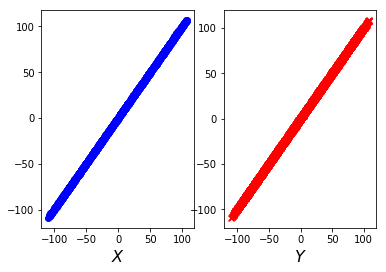

100%|██████████| 24/24 [00:00<00:00, 59.73it/s]

Epoch: 381 Train loss: 3.0098


Test loss: 2.9427


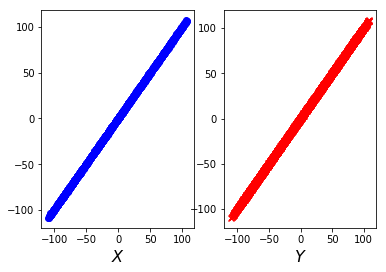

100%|██████████| 24/24 [00:00<00:00, 60.51it/s]

Epoch: 382 Train loss: 3.0049


Test loss: 2.8430


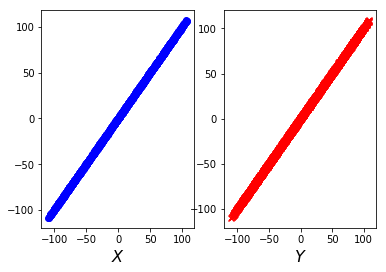

100%|██████████| 24/24 [00:00<00:00, 45.41it/s]

Epoch: 383 Train loss: 3.0315


Test loss: 3.2585


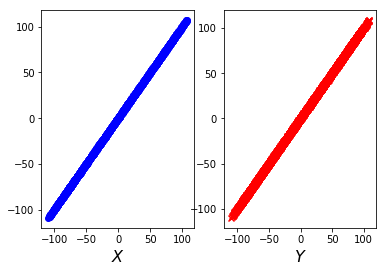

100%|██████████| 24/24 [00:00<00:00, 59.94it/s]

Epoch: 384 Train loss: 2.9840


Test loss: 3.0845


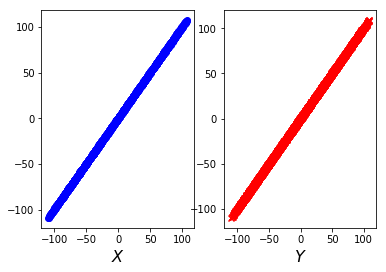

100%|██████████| 24/24 [00:00<00:00, 44.83it/s]

Epoch: 385 Train loss: 3.0092


Test loss: 2.9931


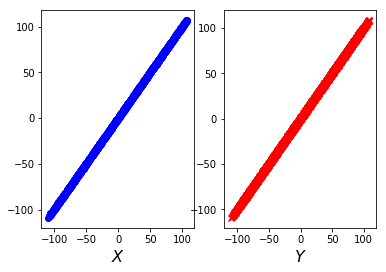

100%|██████████| 24/24 [00:00<00:00, 46.18it/s]

Epoch: 386 Train loss: 2.9875


Test loss: 2.9287


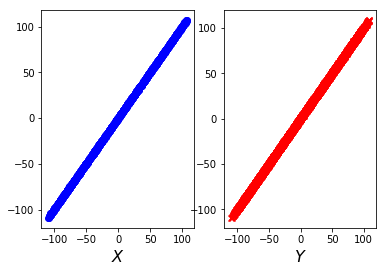

100%|██████████| 24/24 [00:00<00:00, 63.93it/s]

Epoch: 387 Train loss: 3.0023


Test loss: 2.9179


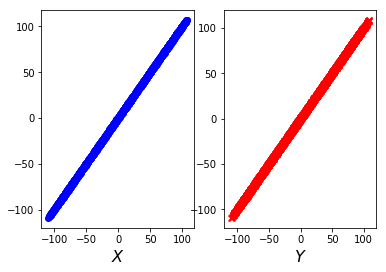

100%|██████████| 24/24 [00:00<00:00, 58.41it/s]

Epoch: 388 Train loss: 2.9439


Test loss: 3.1158


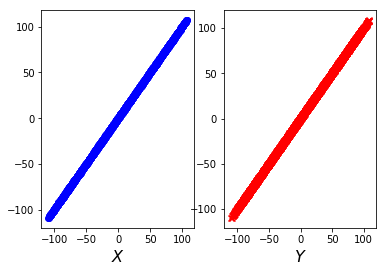

100%|██████████| 24/24 [00:00<00:00, 44.71it/s]

Epoch: 389 Train loss: 3.0172


Test loss: 3.5563


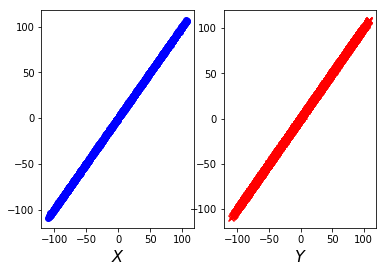

100%|██████████| 24/24 [00:00<00:00, 65.99it/s]

Epoch: 390 Train loss: 3.1262


Test loss: 3.1568


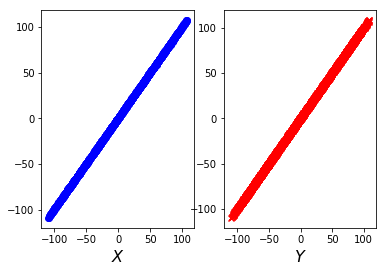

100%|██████████| 24/24 [00:00<00:00, 68.46it/s]

Epoch: 391 Train loss: 3.0606


Test loss: 2.9578


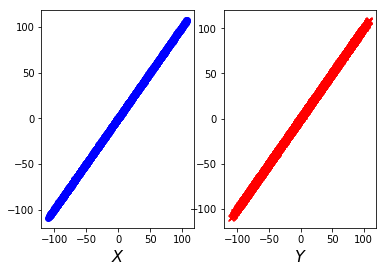

100%|██████████| 24/24 [00:00<00:00, 58.78it/s]

Epoch: 392 Train loss: 2.9387


Test loss: 2.8905


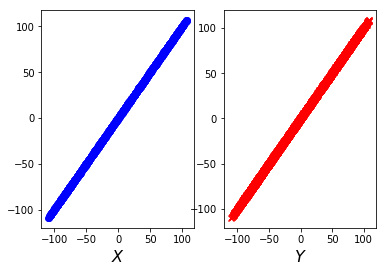

100%|██████████| 24/24 [00:00<00:00, 59.36it/s]

Epoch: 393 Train loss: 2.9495


Test loss: 2.9233


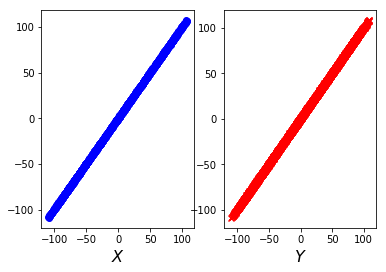

100%|██████████| 24/24 [00:00<00:00, 44.31it/s]

Epoch: 394 Train loss: 2.9954


Test loss: 2.9886


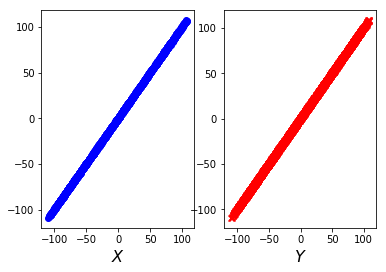

100%|██████████| 24/24 [00:00<00:00, 60.38it/s]

Epoch: 395 Train loss: 2.9658


Test loss: 2.9037


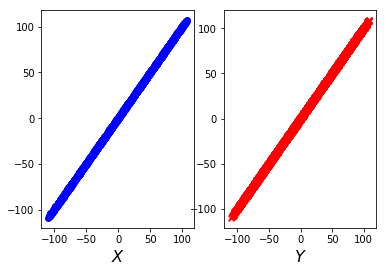

100%|██████████| 24/24 [00:00<00:00, 58.28it/s]

Epoch: 396 Train loss: 2.9610


Test loss: 2.9637


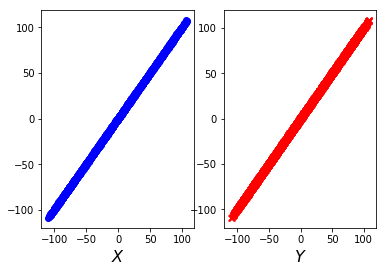

100%|██████████| 24/24 [00:00<00:00, 60.21it/s]

Epoch: 397 Train loss: 3.0449


Test loss: 2.9245


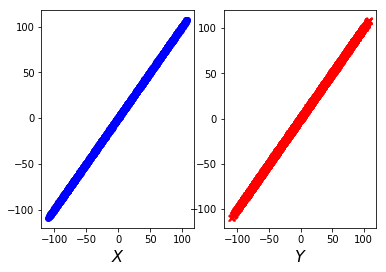

100%|██████████| 24/24 [00:00<00:00, 44.64it/s]

Epoch: 398 Train loss: 2.9205


Test loss: 3.0315


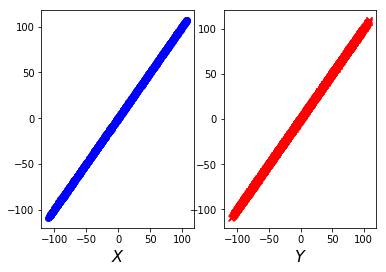

100%|██████████| 24/24 [00:01<00:00, 19.35it/s]

Epoch: 399 Train loss: 3.0326


Test loss: 3.1793


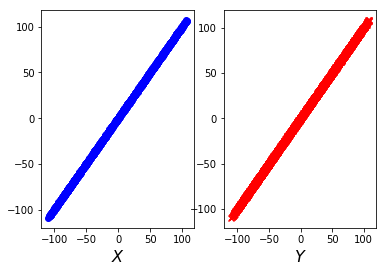

100%|██████████| 24/24 [00:01<00:00, 19.44it/s]

Epoch: 400 Train loss: 3.0368


Test loss: 3.1803


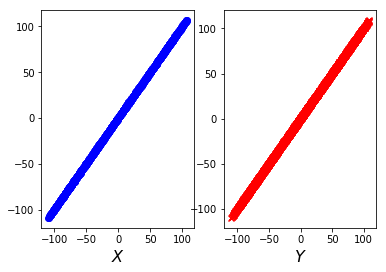

In [57]:
writer = SummaryWriter()

plot_number = 1

s_sample = 0.5 * torch.randn(64, s_dim).to(device)
c_sample = torch.eye(10)[[plot_number]*64].to(device)

# _o, _c = iter(test_loader).next()
# _o = _o.to(device)
# _c = torch.eye(10)[_c].to(device)


for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
#     recon = plot_reconstrunction(_o[:8], _c[:8])
#     sample = plot_image_from_latent(s_sample, c_sample)
#     recon_changing_c = plot_reconstrunction_changing_c(_o[:8], _c[:8])

    writer.add_scalar('train_loss', train_loss.item(), epoch)
    writer.add_scalar('test_loss', test_loss.item(), epoch)
    
    #for plot
    history["train_loss"].append(train_loss.item())
    history["test_loss"].append(test_loss.item())

    _s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device),"st1":data["st1"].to(device),"u":data["u"]}, return_all=False)
    plt.subplot(1, 2, 1)
    tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='blue',marker='o',edgecolors="blue")
    plt.xticks(np.arange(min_data, max_data+grid_inter, grid_inter))
    plt.yticks(np.arange(min_data, max_data+grid_inter, grid_inter))
    plt.set_xlim([min_data,max_data])
    plt.set_ylim([min_data,max_data])
    #plt.ylabel('$$', fontsize=16)
    plt.xlabel('$X$', fontsize=16)
    
    plt.subplot(1, 2, 2)
    sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='red',marker='x',edgecolors="red")
    plt.xticks(np.arange(min_data, max_data+grid_inter, grid_inter))
    plt.yticks(np.arange(min_data, max_data+grid_inter, grid_inter))
    plt.set_xlim([min_data,max_data])
    plt.set_ylim([min_data,max_data])
    plt.xlabel('$Y$', fontsize=16)
    ims.append([tru]+[sam])
    
    x = np.linspace(0,100,1)  # xの値域(0, 1, 2, 3)
    y = x               # 直線の式
    plt.plot(x,y,"r-")      # 直線を引く
    plt.show()
    

#     writer.add_image('Image_from_latent', sample, epoch)
#     writer.add_image('Image_reconstrunction', recon, epoch)
#     writer.add_image('Image_reconstrunction_change_c', recon_changing_c, epoch)
    
writer.close()

In [58]:
# #animation
# def iinit():    
#     return (ims[0])
# # animation function: this is called sequentially
# def animate(i):
#   return (ims[i])

# #plot gif
# fig = plt.figure()
# plt.legend(['True','Result'], loc='upper left', fontsize=16)
# ani = animation.ArtistAnimation(fig, ims)
# anim = animation.FuncAnimation(fig, animate, init_func=iinit, frames=epochs, interval=100, blit=True)
# plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
# HTML(ani.to_html5_video())
# rc('animation', html='jshtml')
# anim

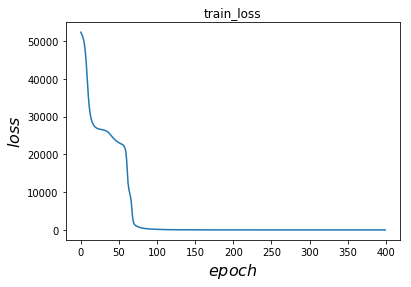

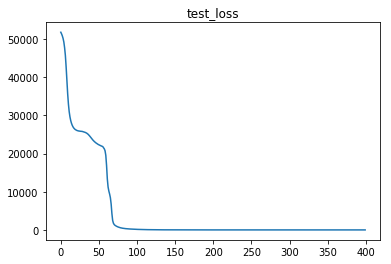

In [59]:
#plot loss    
plt.ylabel('$loss$', fontsize=16)
plt.xlabel('$epoch$', fontsize=16)
plt.title("train_loss")
plt.plot(range(epochs), history["train_loss"])
plt.show()
plt.title("test_loss")
plt.plot(range(epochs), history["test_loss"])
plt.show()

In [60]:
import csv
test_sample_num = 3000
test_sigma=torch.Tensor([0.5,0.5]*test_sample_num).view(test_sample_num,2)

with open('usplus.csv','w') as f:
    for x in [-5.0,0.0,5.0]:
        for y in [-5.0,0.0,5.0]:
            data=unique_datagenerator(test_sample_num,test_sigma,x,y)
            _s = q.sample({"o": data["o"].to(device), "c": data["c"].to(device),"st1":data["st1"].to(device),"u":data["u"]}, return_all=False)
            lossx=0
            lossy=0
            _ss=_s["s"]
            for i in range(0,test_sample_num-1,1):
                lossx+=np.square(data["s"][i][0].numpy()-_ss[i][0].numpy())
                lossy+=np.square(data["s"][i][1].numpy()-_ss[i][1].numpy())
            print(lossx/test_sample_num)
            print(lossy/test_sample_num)
            writer = csv.writer(f, lineterminator='\n')
            writer.writerows([[ lossx/test_sample_num,lossy/test_sample_num ]])

tensor([[-77.6213, -41.5867],
        [ 55.9432,  69.5228],
        [-19.6720, -54.1772],
        ...,
        [ 37.3327,   1.9313],
        [  9.6746,  89.7762],
        [-80.3484, -48.6141]])
tensor([[-5., -5.],
        [-5., -5.],
        [-5., -5.],
        ...,
        [-5., -5.],
        [-5., -5.],
        [-5., -5.]])
tensor([[-82.6213, -46.5867],
        [ 50.9432,  64.5228],
        [-24.6720, -59.1772],
        ...,
        [ 32.3327,  -3.0687],
        [  4.6746,  84.7762],
        [-85.3484, -53.6141]])
0.2180330051046758
0.19353730927045337
tensor([[ 32.0157,   6.3770],
        [-64.6485,  38.3488],
        [-82.8549, -65.8741],
        ...,
        [ 11.5740,  -8.6935],
        [ 39.4692,  32.9233],
        [ 52.3811, -96.2827]])
tensor([[-5.,  0.],
        [-5.,  0.],
        [-5.,  0.],
        ...,
        [-5.,  0.],
        [-5.,  0.],
        [-5.,  0.]])
tensor([[ 27.0157,   6.3770],
        [-69.6485,  38.3488],
        [-87.8549, -65.8741],
        ...,
        

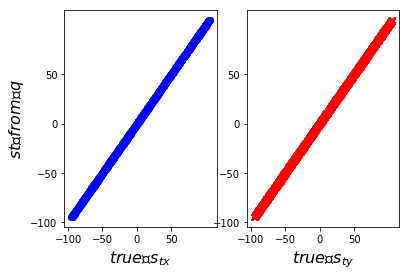

0.22673012277579938
0.20926664321173788


In [61]:
#u_tでの挙動を見るためのテストの描画
plt.subplot(1, 2, 1)
tru = plt.scatter(data["s"][:,0],_s["s"][:,0],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.ylabel('$st　from　q$', fontsize=16)
plt.xlabel('$true　s_{tx}$', fontsize=16)

plt.subplot(1, 2, 2)
sam = plt.scatter(data["s"][:,1],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data,max_data,grid_inter))
plt.yticks(np.arange(min_data,max_data,grid_inter))
plt.xlabel('$true　s_{ty}$', fontsize=16)
ims.append([tru]+[sam])
plt.grid(which='minor',color='black',linestyle='-')
plt.show()

lossx=0
lossy=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    lossx+=np.square(data["s"][i][0].numpy()-_ss[i][0].numpy())
    lossy+=np.square(data["s"][i][1].numpy()-_ss[i][1].numpy())
print(lossx/sample_num)
print(lossy/sample_num)

In [62]:
print(data["s"][:,0])
print(_ss[:,0])

tensor([ 97.2829,  39.5420,  54.4397,  ...,  70.6342, -33.4084, -14.4662])
tensor([ 97.0126,  39.5469,  54.3282,  ...,  69.7226, -33.1761, -16.2090])


In [63]:
print(_s)
print(_o["o"])
print(data["s"])

# plt.scatter(sample_o[:,0],sample_o[:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(data["o"][:,0],data["o"][:,1],color='blue',marker='x',edgecolors="red")
plt.scatter(_o["o"][:,0],_o["o"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

{'s': tensor([[ 97.0126, -44.1507],
        [ 39.5469, -88.0708],
        [ 54.3282,  15.8068],
        ...,
        [ 69.7226, -92.6558],
        [-33.1761,  10.4606],
        [-16.2090, -90.1330]])}


NameError: name '_o' is not defined

In [ ]:
loss=0
_ss=_s["s"]
for i in range(0,sample_num-1,1):
    loss+=np.square(data["s"][i].numpy()-_ss[i])
print(loss/sample_num)

In [ ]:
max_data=10#max_data
min_data=-4#min_data
grid_inter=1

plot_data=test_data

_s = q.sample({"o": plot_data["o"].to(device), "c": plot_data["c"].to(device)}, return_all=False)

#show sample points
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xlabel('$sx$', fontsize=16)
plt.ylabel('$sy$', fontsize=16)
plt.title("Simulated dataset")
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(plot_data["s"][:,0],plot_data["s"][:,1],color='blue',marker='o',edgecolors="blue")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.subplot(1,2,2)
plt.scatter(_s["s"][:,0],_s["s"][:,1],color='red',marker='x',edgecolors="red")
plt.xticks(np.arange(min_data-1,max_data+1,grid_inter))
plt.show()
